---
# Part 1 - Results from the GS's are Analyzed 
---
- purpose of the Part 1 of thenotebook is to analyze the metrics from an initial exploratory gridsearch 
- after this largetr GS, i run a more concentrated GS with less parameters , parameters are eliminated based on the visual analysis below 
- more robust methods may be used but this works for now 

In [1]:
import pandas as pd
import pickle
import random
import numpy as np
import os
import itertools
from joblib import Parallel, delayed , parallel_backend
from collections import defaultdict
import math
import torch.nn as nn
import json

import Equations_Ensembles_Dist



from Equations_Run_Combo_V_2 import (


    run_combo,
    LSTM,
    TimeSeriesDataset,
    format_to_tensor,
    train_one_epoch,
    validate_one_epoch,
    evaluate_binary_0_1,
    evaluate_signed_neg1_1 ,
)


In [5]:
import json 

with open("/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/full_results_chunk_1_100_CHUNKS_8fold_05NEG__VERSION_4__DISCOVERY.json") as f:

    data = json.load(f)

In [3]:


#------------------------------------------------------------------------------------------------------------------------------------------------------------

#                                           THE COMMENTED OUT CODE BELOW IS FOR THE GS USED TO GENERATE THE DISTRIBUTIONS BELOW 

#                                            THIS IS THE INITIAL PARAMS USED TO FILER OUT PARAMETERS FOR THE FINAL SEARCH 

#                                   HOW IT WORKS : -> PREPARE A LARGE GS, RANDOMLY sample from the combinations for equal representation fo parameters 
#                                                  -> asses results to cut out paramets from the search -> complete final search 



#------------------------------------------------------------------------------------------------------------------------------------------------------------



# param_grid = {
#     "learning_rate": [0.05, 0.005, 0.0005],
#     "num_epochs": [20, 70, 150, 300, 700, 1000],
#     "batch_size": [10, 30, 50],
#     "use_bidirectional": [True, False],
#     "lag": [1, 2, 3, 6],
#     "input_size": [12],
#     "hidden_size": [5, 12, 20, 25, 35, 55],
#     "num_layers": [1, 2, 4],
#                                             "use_monthly_dfs_only": [True],
    
    
#                                             "use_binary_0_1": [False],


#     "use_binary_neg1_1": [False],  # still to be investigated
#     "use_ret_rate": [False],       # still to be investigated
#     "use_print_acc": [False],      # still to be investigated
#     "use_dropout": [False, True],  # still to be investigated

#     "use_class_weighting": [True, False],
#     # missing params 
#     "is_deterministic": [True],     
#     "seed_num": [42],       


#     "use_monthly_predictor": [False],
    
    
#     "use_existing_lagged_data": [True],
#     'use_dynamic_weights' : [False] ,


# ########################################################################################

#     'use_monthly_daily_end_mo_predictor' : [False], 
#     'use_monthly_weekly_end_mo_predictor' : [True]  ,  

#     'use_binary_0_1_custom_neg' : [True] ,
#     'use_binary_0_1_custom_pos' : [False] ,
    
#     'binary_0_1_cutoff_ret_rate_percentage' : [.05],  ### cutoff for the  use_binary_0_1_custom_pos ot use_binary_0_1_custom_neg
#     'end_value_train_set_fraction' : [0.85], 
#     'val_set_fraction' : [0.1], 
#     'num_folds' : [8]  , 
#     'POS_weight_multiplier' : [  .1 , .5 ,  .7 ,  1  ,  1.1  ,   1.3   ] , ## 24 vals is val set, 3 units per ser fi folds are 8 
#     'use_rolling_fixed_train_size' : [False,True],
#     'use_existing_initial_weights': [False], 
#     'state_dict' : [None]
        
#         }   




# # --- Prepare all combinations ---
# keys, values = zip(*param_grid.items())
# combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

# # --- Randomly discard 30% of combinations ---
# def random_subset(data,  seed=42):
#     random.seed(seed)
#     n_keep = int(len(data))
#     return random.sample(data, n_keep)


# # --- Split combinations into chunks ---
# def split_into_chunks(lst, n_chunks):
#     chunk_size = len(lst) // n_chunks
#     chunks = []
#     for i in range(n_chunks):
#         start = i * chunk_size
#         end = (i + 1) * chunk_size if i < n_chunks - 1 else len(lst)
#         chunks.append(lst[start:end])
#     return chunks


# random_subset_combos = random_subset(combinations, seed=42)

# FRACTION_TO_KEEP = .9  ; fraction_idx = int(len(random_subset_combos) * FRACTION_TO_KEEP)


# n_chunks = 50
# combo_chunks = split_into_chunks(random_subset_combos[:fraction_idx], n_chunks)
# # combo_chunks = split_into_chunks(combinations, n_chunks)

# chunk_to_run = 0 #    <<------- 


# selected_chunk = combo_chunks[chunk_to_run]



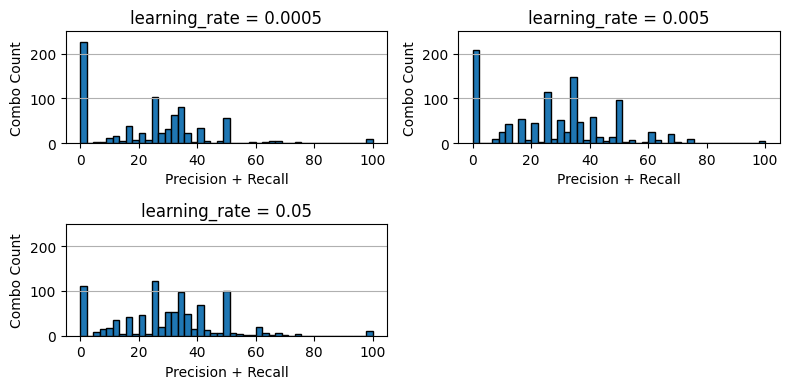

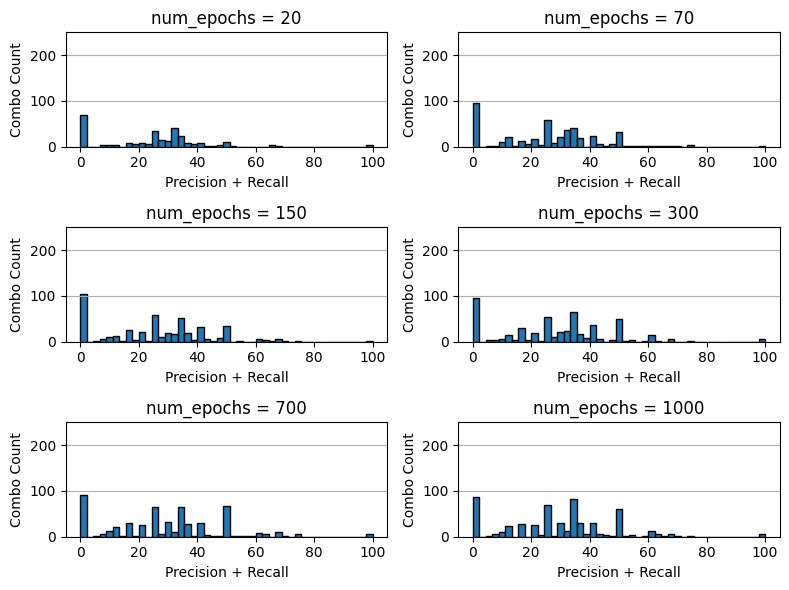

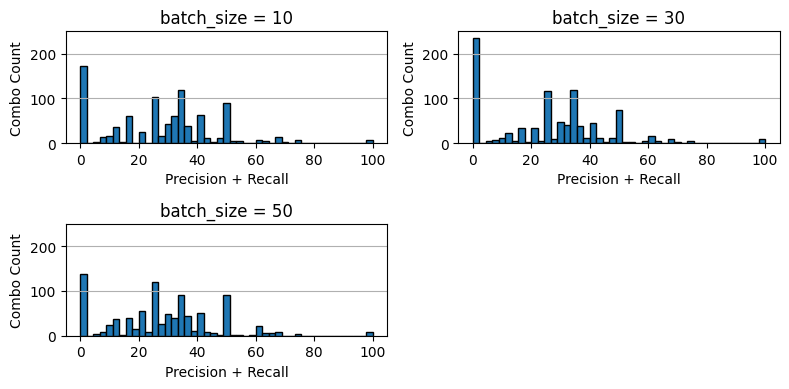

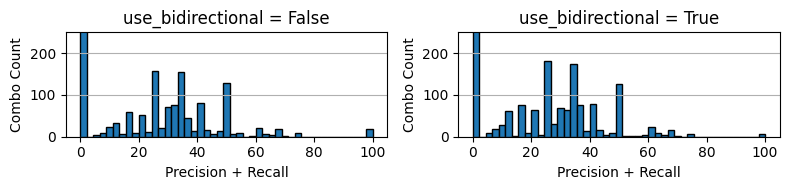

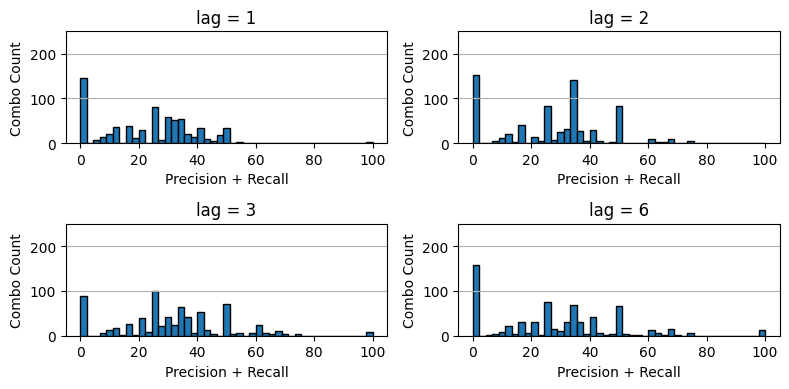

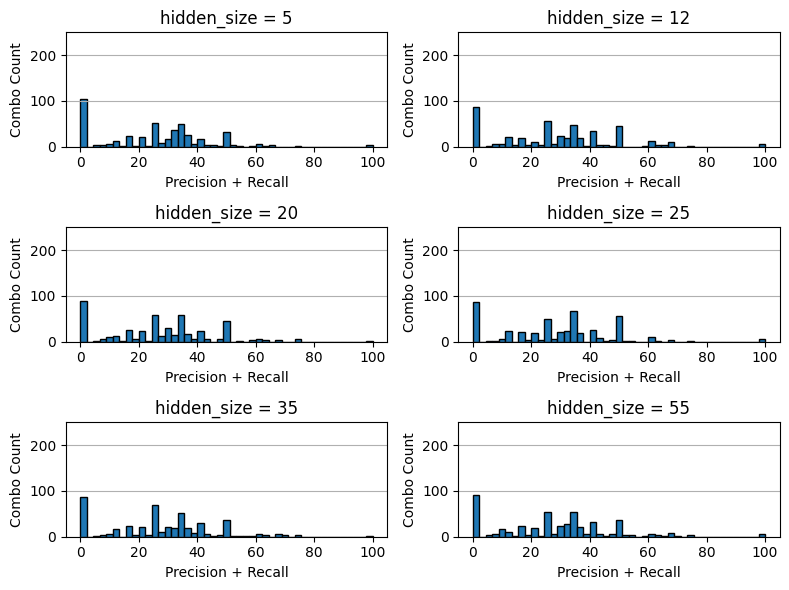

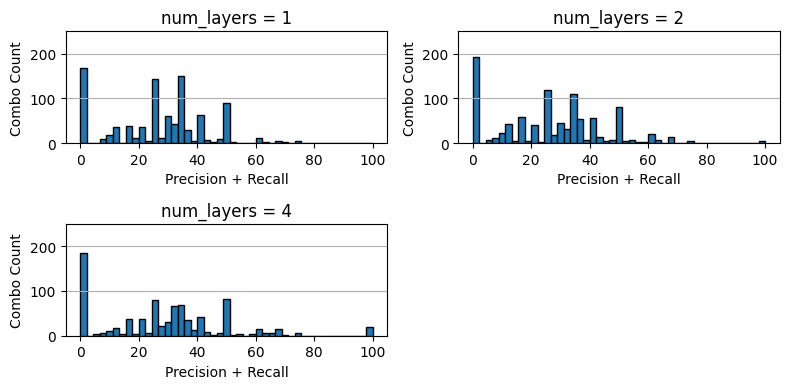

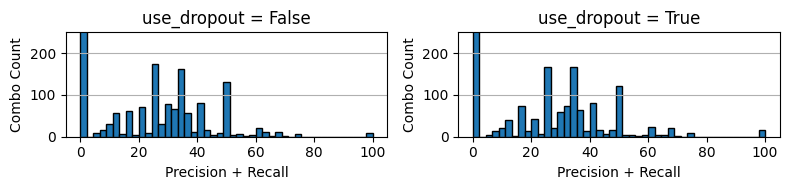

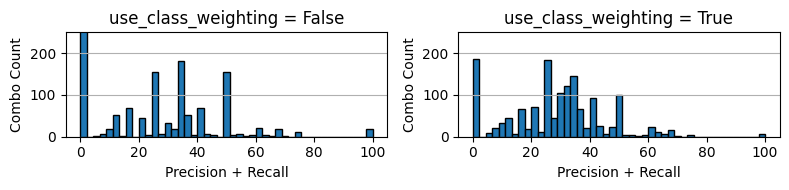

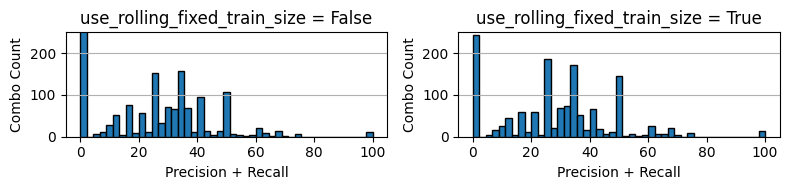

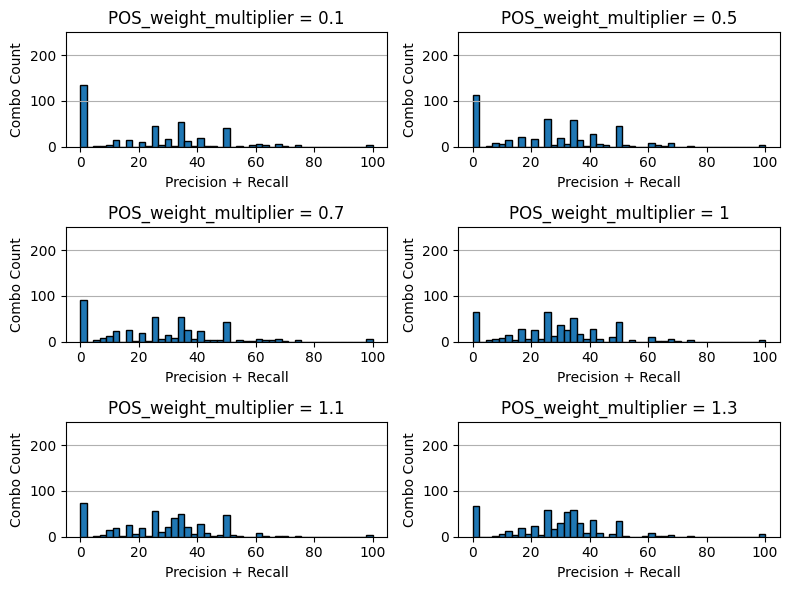

In [4]:


import matplotlib.pyplot as plt
from collections import Counter
import math



list = [ "learning_rate" , "num_epochs"  ] 


import matplotlib.pyplot as plt
from collections import Counter
import math

param_list = ["learning_rate", "num_epochs"  , "batch_size" , "use_bidirectional" , 
              "lag" ,"hidden_size" ,"num_layers" , "use_dropout" , "use_class_weighting" , 'use_rolling_fixed_train_size' , 'POS_weight_multiplier']


for param in param_list:

    # Get unique values for this parameter
    values = sorted(set(entry['parameters'][param] for entry in data))
    n = len(values)

    cols = 2
    rows = math.ceil(n / cols)

    plt.figure(figsize=(4 * cols, 2 * rows))

    for k, val in enumerate(values):
        avg_scores = []

        for entry in data:
            if entry['parameters'][param] == val:
                avg_dict = entry.get('cv_sets', {}).get('avg_across_all_sets', {})
                prec = avg_dict.get('precision_up')
                rec = avg_dict.get('recall_up')

                if prec is not None and rec is not None:
                    avg_scores.append(prec)  # or (prec + rec)/2 if you want average

        plt.subplot(rows, cols, k + 1)
        plt.hist(avg_scores, bins=45, edgecolor='black')
        plt.title(f"{param} = {val}")
        plt.xlabel("Precision + Recall")
        plt.ylabel("Combo Count")
        plt.grid(axis='y')
        plt.ylim(0,250)

    plt.tight_layout()
    plt.show()


---
# Part 2 - Final GS Results Exploration
---

In [5]:
### NOTE UNCOMMENT OT SEE DIST OF RESULTS  

# import json 

# with open("/Users/cs/Desktop/full_results_chunk_1_25_CHUNKS_8fold_05NEG__VERSION_4__GSresults.json") as f:

#     data = json.load(f)


# import matplotlib.pyplot as plt
# from collections import Counter
# import math



# list = [ "learning_rate" , "num_epochs"  ] 


# import matplotlib.pyplot as plt
# from collections import Counter
# import math

# param_list = ["learning_rate", "num_epochs"  , "batch_size" , "use_bidirectional" , 
#               "lag" ,"hidden_size" ,"num_layers" , "use_dropout" , "use_class_weighting" , 'use_rolling_fixed_train_size' , 'POS_weight_multiplier']


# for param in param_list:

#     # Get unique values for this parameter
#     values = sorted(set(entry['parameters'][param] for entry in data))
#     n = len(values)

#     cols = 2
#     rows = math.ceil(n / cols)

#     plt.figure(figsize=(6 * cols, 4 * rows))

#     for k, val in enumerate(values):
#         avg_scores = []

#         for entry in data:
#             if entry['parameters'][param] == val:
#                 avg_dict = entry.get('cv_sets', {}).get('avg_across_all_sets', {})
#                 prec = avg_dict.get('precision_up')
#                 rec = avg_dict.get('recall_up')

#                 if prec is not None and rec is not None:
#                     avg_scores.append(prec)  # or (prec + rec)/2 if you want average

#         plt.subplot(rows, cols, k + 1)
#         plt.hist(avg_scores, bins=45, edgecolor='black')
#         plt.title(f"{param} = {val}")
#         plt.xlabel("Precision + Recall")
#         plt.ylabel("Combo Count")
#         plt.grid(axis='y')
#         plt.ylim(0,50)
#         plt.xlim(45,100)

#     plt.tight_layout()


In [6]:
import pandas as pd
import pickle
import random
import numpy as np
import os
import itertools
from joblib import Parallel, delayed ,parallel_backend
from collections import defaultdict
import math
import torch.nn as nn
import json 



from Equations_Run_Combo_V_2 import (

    run_combo,LSTM,
    TimeSeriesDataset,format_to_tensor, train_one_epoch,
    validate_one_epoch, evaluate_binary_0_1, evaluate_signed_neg1_1 ,
)

import pickle
with open('/Users/cs/Desktop/Oil-LSTM-Project-2/short_dfs.pkl', 'rb') as f:
    loaded_dfs = pickle.load(f)

with open("/Users/cs/Desktop/Oil-LSTM-Project-2/lagged_cache.pkl", "rb") as f:
    lagged_cache = pickle.load(f)


#/home/charifslmn/

In [9]:
#--------------                              ORIGINAL CODE 
for i in range(1):  
    with open(f'/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/Incomplete Results/full_results_chunk_1_25_CHUNKS_8fold_05NEG__VERSION_4__GSresults.json', 'r') as f:
        results = json.load(f)


for i in range(1):  
    with open(f'/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/Incomplete Results/full_results_chunk_1_20_CHUNKS_8fold_05NEG__VERSION_4_2.json', 'r') as f:
        results2 = json.load(f)

for res in results2:
    results.append(res)
#--------------


with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/results_8fold_05NEG_best_models_GC_V_overtall_metrics_FIX.json' , 'r') as f_json:
   results3 =  json.load(f_json)
    



In [8]:
# #                                          CODE TO PRINT MODELS TO FIX BY ADDING OVERALL RESUTLS FIX - COMPUTED ON GC       DO NOT DELETE, READ 

# import json
# import numpy as np
# import copy


# #--------------                              ORIGINAL CODE 
# for i in range(1):  
#     with open(f'/Users/cs/Desktop/Incomplete Results/full_results_chunk_1_25_CHUNKS_8fold_05NEG__VERSION_4__GSresults.json', 'r') as f:
#         results = json.load(f)


# for i in range(1):  
#     with open(f'/Users/cs/Desktop/Incomplete Results/full_results_chunk_1_20_CHUNKS_8fold_05NEG__VERSION_4_2.json', 'r') as f:
#         results2 = json.load(f)

# for res in results2:
#     results.append(res)
# #--------------



# # with open(f'/Users/cs/Desktop/Incomplete Results/full_results_chunk_1_25_CHUNKS_8fold_05NEG__VERSION_4__GSresults.json', 'r') as f:
# #     results = json.load(f)

# scored_results = []
# for entry in results:
#     avg = entry['cv_sets'].get('avg_across_all_sets', {})
#     acc = avg.get('accuracy') or 0.0
#     prec_up = avg.get('precision_up') or 0.0
#     recall_up = avg.get('recall_up') or 0.0

#     total_score = acc  # or add prec_up, etc.
    
#     sets = entry["cv_sets"]
#     acc_3 = sets.get("set_3", {}).get("accuracy")
#     acc_5 = sets.get("set_5", {}).get("accuracy")
#     acc_6 = sets.get("set_6", {}).get("accuracy")

#     # if acc_3 == (100.0  ) and acc_5 == (100.0 or 66.66666666666666 ) and acc_6 == (100.0  ) and recall_up > 20 and prec_up > 70:
#     # if acc_3 == (100.0) and acc_5 == (100.0) and acc_6 == (100.0) and recall_up > 20 and prec_up > 80:

#     scored_results.append((total_score, entry))

# # Step 2: Sort by score descending
# scored_results.sort(reverse=True, key=lambda x: x[0])

# # Step 3: Extract top 10 entries
# top = scored_results[:70]

# for i, j in top:
#     print(j["combo_number"], '<--->' , j["cv_sets"]["avg_across_all_sets"] , '<---->' , j["parameters"] )

# # Step 4: Extract the parameter combos
# combos = [j["parameters"] for i, j in top]


# combos_test_param = []

# for i in combos:
#     i_copy = copy.deepcopy(i)
#     i_copy["val_set_fraction"] = 0.05
#     i_copy["num_folds"] = 4
#     i_copy["end_value_train_set_fraction"] = 0.95
#     combos_test_param.append(i_copy)


# len(top)
# len(combos)


In [10]:
import json
import numpy as np
import copy


# with open(f'/Users/cs/Desktop/Incomplete Results/full_results_chunk_1_25_CHUNKS_8fold_05NEG__VERSION_4__GSresults.json', 'r') as f:
#     results = json.load(f)



with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/results_8fold_05NEG_best_models_GC_V_overtall_metrics_FIX.json' , 'r') as f_json:
   results3 =  json.load(f_json)


scored_results = []
for entry in results3:
    avg = entry['cv_sets'].get('overall_metrics', {})
    acc = avg.get('accuracy') or 0.0
    prec_up = avg.get('precision_up') or 0.0
    recall_up = avg.get('recall_up') or 0.0

    total_score = acc  # or add prec_up, etc.
    
    sets = entry["cv_sets"]
    acc_3 = sets.get("set_3", {}).get("accuracy")
    acc_5 = sets.get("set_5", {}).get("accuracy")
    acc_6 = sets.get("set_6", {}).get("accuracy")

    # if acc_3 == (100.0  ) and acc_5 == (100.0 or 66.66666666666666 ) and acc_6 == (100.0  ) and recall_up > 20 and prec_up > 70:
    # if acc_3 == (100.0) and acc_5 == (100.0) and acc_6 == (100.0) and recall_up > 20 and prec_up > 80:
    if recall_up > 20 and prec_up > 75:

        scored_results.append((total_score, entry))

# Step 2: Sort by score descending
scored_results.sort(reverse=True, key=lambda x: x[0])

# Step 3: Extract top 10 entries
top = scored_results[:70]

for i, j in top:
    print(j["combo_number"], '<--->' , j["cv_sets"]["overall_metrics"] , '<---->' , j["parameters"] )

# Step 4: Extract the parameter combos
combos = [j["parameters"] for i, j in top]


combos_test_param = []

for i in combos:
    i_copy = copy.deepcopy(i)
    i_copy["val_set_fraction"] = 0.05
    i_copy["num_folds"] = 4
    i_copy["end_value_train_set_fraction"] = 0.95
    combos_test_param.append(i_copy)


len(top)
len(combos)




# #### ----------------------                 RUN COMBOS
# with parallel_backend("loky", n_jobs=-1):
#     results = Parallel()(
#         delayed(run_combo)(0, combo, i, use_print_acc_vs_pred=False)
        
#         for i, (combo) in enumerate(combos_test_param)
#     )

# res , w = zip(*results)

# import copy

# metrics_c = copy.deepcopy(res)

# for m in metrics_c:
#     # Convert all_preds from arrays → lists of lists
#     m["all_preds"] = [pred.tolist() if hasattr(pred, "tolist") else pred for pred in m["all_preds"]]
#     m["all_actuals"] = [act.tolist() if hasattr(act, "tolist") else act for act in m["all_actuals"]]
#     m["raw_actuals"] = [act.tolist() if hasattr(act, "tolist") else act for act in m["raw_actuals"]]
    

# res_name = f"/Users/cs/Desktop/results_8fold_05NEG_preds_best_models_GC_V_2.json"
# # # file_weights = f"/Users/cs/Desktop/full_results_chunk_{chunk_to_run + 1}_{n_chunks}_WEIGHTS_8fold_05NEG__VERSION_2.pt"

# with open(res_name, "w") as f_json:
#     json.dump(metrics_c, f_json, indent=2)




1 <---> {'accuracy': 91.66666666666666, 'precision_up': 87.5, 'recall_up': 87.5, 'precision_down': 93.75, 'recall_down': 93.75} <----> {'learning_rate': 0.05, 'num_epochs': 700, 'batch_size': 10, 'use_bidirectional': False, 'lag': 3, 'input_size': 12, 'hidden_size': 12, 'num_layers': 2, 'use_monthly_dfs_only': True, 'use_binary_0_1': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': True, 'use_class_weighting': False, 'is_deterministic': True, 'seed_num': 42, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_custom_neg': True, 'use_binary_0_1_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.85, 'val_set_fraction': 0.1, 'num_folds': 8, 'POS_weight_multiplier': 0.1, 'use_rolling_fixed_train_size': False, 'use_existing_initial_weights': False

25

---
# Part 3 : Master df and Correlation Exploration 
---

In [ ]:

with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/V_05NEG_best_models_results/results_8fold_05NEG_preds_best_models_MAC_V_2.json' , 'r') as f_json:
   res_mac_val =  json.load(f_json)


len(res_mac_val)

25

In [ ]:
import pandas as pd
import copy

with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/V_05NEG_best_models_results/results_8fold_05NEG_preds_best_models_MAC_V_2.json' , 'r') as f_json:
   res_mac_val =  json.load(f_json)

with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/V_05NEG_best_models_results/results_TESTfold_05NEG_preds_best_models_MAC_V_2.json' , 'r') as f_json:
   res_mac_test =  json.load(f_json)

with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/V_05NEG_best_models_results/results_8fold_05NEG_preds_best_models_GC_V_2.json' , 'r') as f_json:
   res_gc_val =  json.load(f_json)

with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/V_05NEG_best_models_results/results_TESTfold_05NEG_preds_best_models_GC_V_2.json' , 'r') as f_json:
   res_gc_test =  json.load(f_json)



def flatten_results(result_list):
    """Flatten one list of results into a DataFrame without modifying the original."""
    flattened = []
    for entry in result_list:
        flat_entry = {k: v for k, v in entry.items() if k != "cv_sets"}
        flat_entry.update(entry["cv_sets"])
        flattened.append(flat_entry)
    return pd.DataFrame(flattened)

# Create new DataFrames for each result set
df_mac_val  = flatten_results(res_mac_val)
df_mac_test = flatten_results(res_mac_test)
df_gc_val   = flatten_results(res_gc_val)
df_gc_test  = flatten_results(res_gc_test)

dfs = [df_mac_val, df_mac_test, df_gc_val, df_gc_test]

### ---- number of up predictions made 
for df in dfs:
    no_up_list = []  

    for row in df["all_preds"]:

        flat_preds = [p for fold in row for p in fold]
        no_up_list.append(sum(p > 0.5 for p in flat_preds))

    df["no_up_preds"] = no_up_list


# ---- Crate a col that keeps track of the actual change when there was a false up pred 
for df in dfs:
        
    false_up_preds_col_list = []
    for row_raw_actuals, row_01_actuals , row_preds in zip(df["raw_actuals"] ,df["all_actuals"] , df["all_preds"]):
        
        false_up_preds_row = []

        row_raw_actuals_flattened = [p for fold in row_raw_actuals for p in fold ]
        row_01_actuals_flattened = [p for fold in row_01_actuals for p in fold ]
        row_preds_flattened = [p for fold in row_preds for p in fold]

        for entry_raw_actual,entry_01_actual , entry_pred in zip(row_raw_actuals_flattened , row_01_actuals_flattened,row_preds_flattened ):
            
            if entry_pred > 0.5 and entry_01_actual < 0.5:
                false_up_preds_row.append(round(entry_raw_actual,3)) 

        false_up_preds_col_list.append(false_up_preds_row)


    df["actuals_false_up"] = false_up_preds_col_list
# ---- Crate a col that keeps track of the actual change when there was a false up pred 

for df in dfs:
    df.rename(columns={"overall_metrics": "overall"}, inplace=True)

# ---- Flatten "parameters" dict column for each DataFrame ----
for df in (df_mac_val, df_mac_test, df_gc_val, df_gc_test):
    if "overall" in df.columns:
        params_df = pd.json_normalize(df["overall"])
        params_df.columns = [f"OA_{col}" for col in params_df.columns]
        df[params_df.columns] = params_df

df_gc_test.columns

dfs = [df_mac_val, df_mac_test, df_gc_val, df_gc_test]

for df in dfs:
    params_chosen = []
    for param_dict in df["parameters"]:
        param_dict_fix = {}
        for param_key in param_dict.keys():
            if param_key not in ['num_folds', 'end_value_train_set_fraction', 'val_set_fraction']:
                param_dict_fix[str(param_key)] = param_dict[param_key]

        params_chosen.append(str(param_dict_fix))
    
    df["params_fix"] = params_chosen


dict_fic_params = {}
for idx, p in enumerate(df_gc_test["params_fix"]):
    p_str = str(p).replace(' ','').replace("'",'').replace('  ','')
    dict_fic_params[p_str] = idx


for df in (df_mac_val, df_mac_test, df_gc_val, df_gc_test):
    param_values = []
    for p in df["params_fix"]:
        p_str = str(p).replace(' ','').replace("'",'')

        param_values.append(dict_fic_params[p_str])
    df["param_int_value"] = param_values


# Append suffix based on variable name
df_mac_val.rename(columns=lambda x: f"{x}_mac_val" if x != "params_fix" else x, inplace=True)
df_mac_test.rename(columns=lambda x: f"{x}_mac_test" if x != "params_fix" else x, inplace=True)
df_gc_val.rename(columns=lambda x: f"{x}_gc_val" if x != "params_fix" else x, inplace=True)
df_gc_test.rename(columns=lambda x: f"{x}_gc_test" if x != "params_fix" else x, inplace=True)


master_df = (
    df_mac_val
    .merge(df_mac_test, on="params_fix", how="outer")
    .merge(df_gc_val, on="params_fix", how="outer")
    .merge(df_gc_test, on="params_fix", how="outer")
)


master_df.columns = (
    master_df.columns
      .str.replace('precision', 'prec')
      .str.replace('recall', 'rec')
      .str.replace('down', '0')
      .str.replace('up', '1')
      .str.replace('accuracy', 'acc')
      .str.replace('test', 'T')
      .str.replace('val', 'V')

)

master_df.columns

Index(['combo_number_mac_V', 'parameters_mac_V', 'all_preds_mac_V',
       'all_actuals_mac_V', 'raw_actuals_mac_V', 'set_1_mac_V', 'set_2_mac_V',
       'set_3_mac_V', 'set_4_mac_V', 'set_5_mac_V', 'set_6_mac_V',
       'set_7_mac_V', 'set_8_mac_V', 'avg_across_all_sets_mac_V',
       'overall_mac_V', 'no_1_preds_mac_V', 'actuals_false_1_mac_V',
       'OA_acc_mac_V', 'OA_prec_1_mac_V', 'OA_rec_1_mac_V', 'OA_prec_0_mac_V',
       'OA_rec_0_mac_V', 'params_fix', 'param_int_Vue_mac_V',
       'combo_number_mac_T', 'parameters_mac_T', 'all_preds_mac_T',
       'all_actuals_mac_T', 'raw_actuals_mac_T', 'set_1_mac_T', 'set_2_mac_T',
       'set_3_mac_T', 'set_4_mac_T', 'avg_across_all_sets_mac_T',
       'overall_mac_T', 'no_1_preds_mac_T', 'actuals_false_1_mac_T',
       'OA_acc_mac_T', 'OA_prec_1_mac_T', 'OA_rec_1_mac_T', 'OA_prec_0_mac_T',
       'OA_rec_0_mac_T', 'param_int_Vue_mac_T', 'combo_number_gc_V',
       'parameters_gc_V', 'all_preds_gc_V', 'all_actuals_gc_V',
       'raw_actu

In [12]:
# master_df.columns =  (master_df.columns.str.replace('_', '\n'))


master_df[ ["OA_prec_1_gc_V" , "OA_rec_1_gc_V" , "no_1_preds_gc_V" , "actuals_false_1_gc_V" 
            
            ,"OA_prec_1_gc_T" , "OA_rec_1_gc_T" , "no_1_preds_gc_T", "actuals_false_1_gc_T" ,

            "OA_prec_1_mac_V" ,"OA_rec_1_mac_V"  ,  "no_1_preds_mac_V", "actuals_false_1_mac_V" ,
            
            "OA_prec_1_mac_T" ,"OA_rec_1_mac_T"  ,  "no_1_preds_mac_T", "actuals_false_1_mac_T" ,   ]
            
            ].round(2)

OA_prec_1_gc_V  OA_rec_1_gc_V  no_1_preds_gc_V actuals_false_1_gc_V  \
0           100.00           25.0                2                   []   
1           100.00           37.5                3                   []   
2           100.00           25.0                2                   []   
3           100.00           25.0                2                   []   
4           100.00           25.0                2                   []   
5           100.00           25.0                2                   []   
6           100.00           25.0                2                   []   
7            80.00           50.0                5              [0.055]   
8           100.00           25.0                2                   []   
9           100.00           25.0                2                   []   
10           80.00           50.0                5              [0.068]   
11           80.00           50.0                5              [0.068]   
12           80.00           50.0                5              [0.186]   
13          100.00           25.0                2                   []   
14           83.33           62.5                6               [0.19]   
15           83.33           62.5                6               [0.19]   
16           80.00           50.0                5              [-0.01]   
17          100.00           25.0                2                   []   
18          100.00           25.0                2                   []   
19           80.00           50.0                5             [-0.038]   
20           83.33           62.5                6               [0.19]   
21           87.50           87.5                8              [0.046]   
22          100.00           25.0                2                   []   
23           80.00           50.0                5              [0.059]   
24          100.00           25.0                2                   []   

    OA_prec_1_gc_T  OA_rec_1_gc_T  no_1_preds_gc_T  \
0            25.00           20.0                4   
1            66.67           80.0                6   
2             0.00            0.0                1   
3             0.00            0.0                3   
4              NaN            0.0                0   
5           100.00           20.0                1   
6           100.00           20.0                1   
7            33.33           60.0                9   
8             0.00            0.0                3   
9              NaN            0.0                0   
10            0.00            0.0                2   
11          100.00           20.0                1   
12          100.00           60.0                3   
13             NaN            0.0                0   
14           50.00           20.0                2   
15           50.00           20.0                2   
16          100.00           20.0                1   
17             NaN            0.0                0   
18             NaN            0.0                0   
19           50.00           20.0                2   
20           50.00           20.0                2   
21           50.00           20.0                2   
22           40.00           40.0                5   
23          100.00           20.0                1   
24             NaN            0.0                0   

                           actuals_false_1_gc_T  OA_prec_1_mac_V  \
0                        [-0.022, 0.233, 0.102]            40.00   
1                                [0.233, 0.097]             0.00   
2                                      [-0.049]            66.67   
3                         [0.143, 0.233, 0.102]            50.00   
4                                            []           100.00   
5                                            []           100.00   
6                                            []           100.00   
7   [-0.022, 0.143, 0.06, 0.102, -0.049, 0.097]            33.33   
8                          [0.143, 0

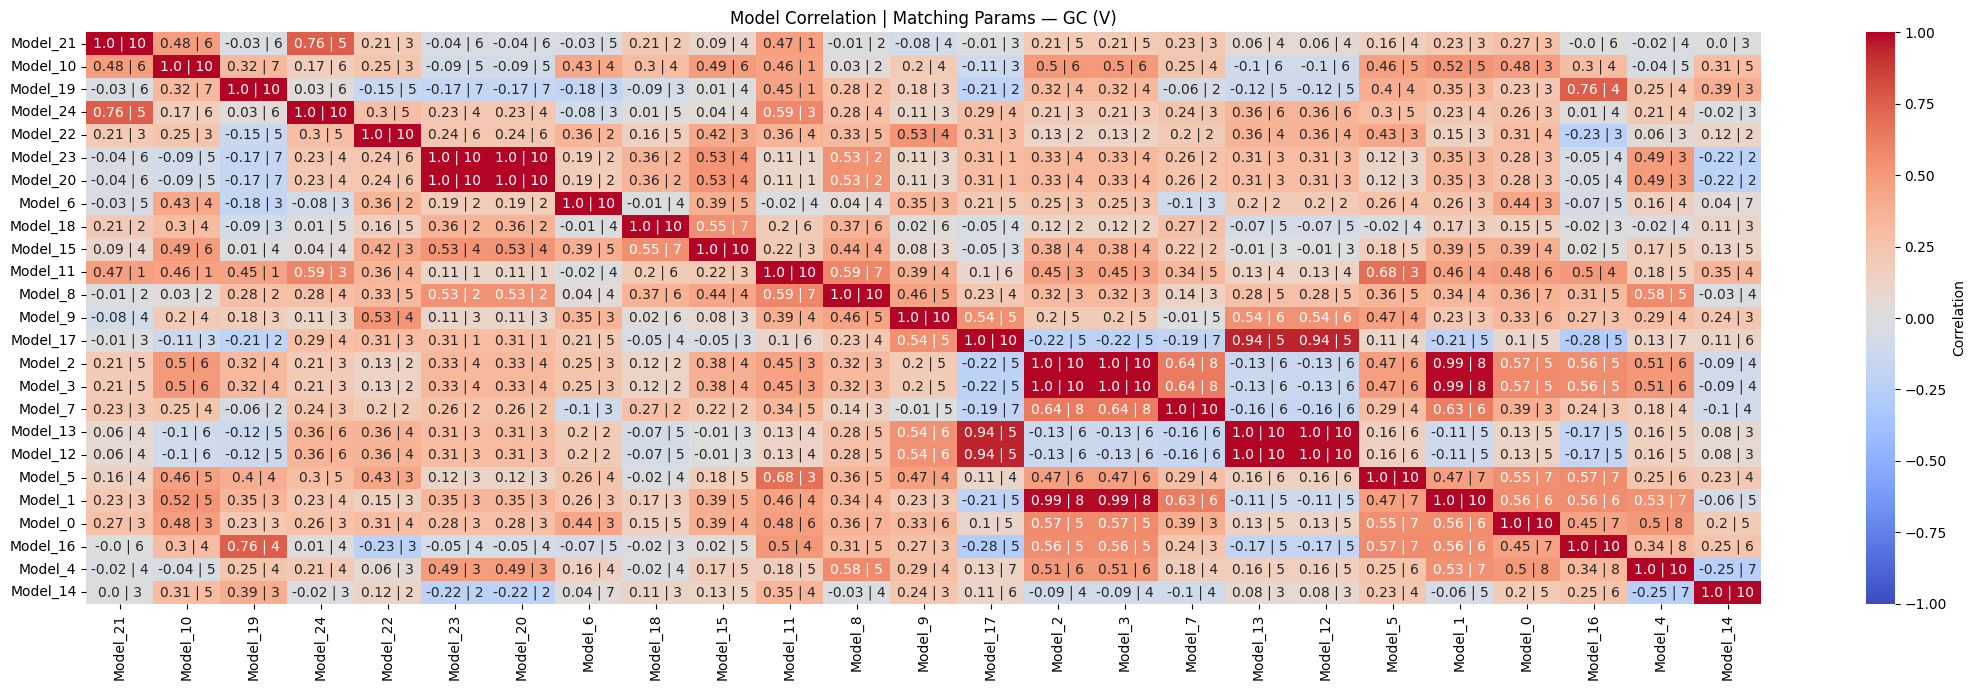

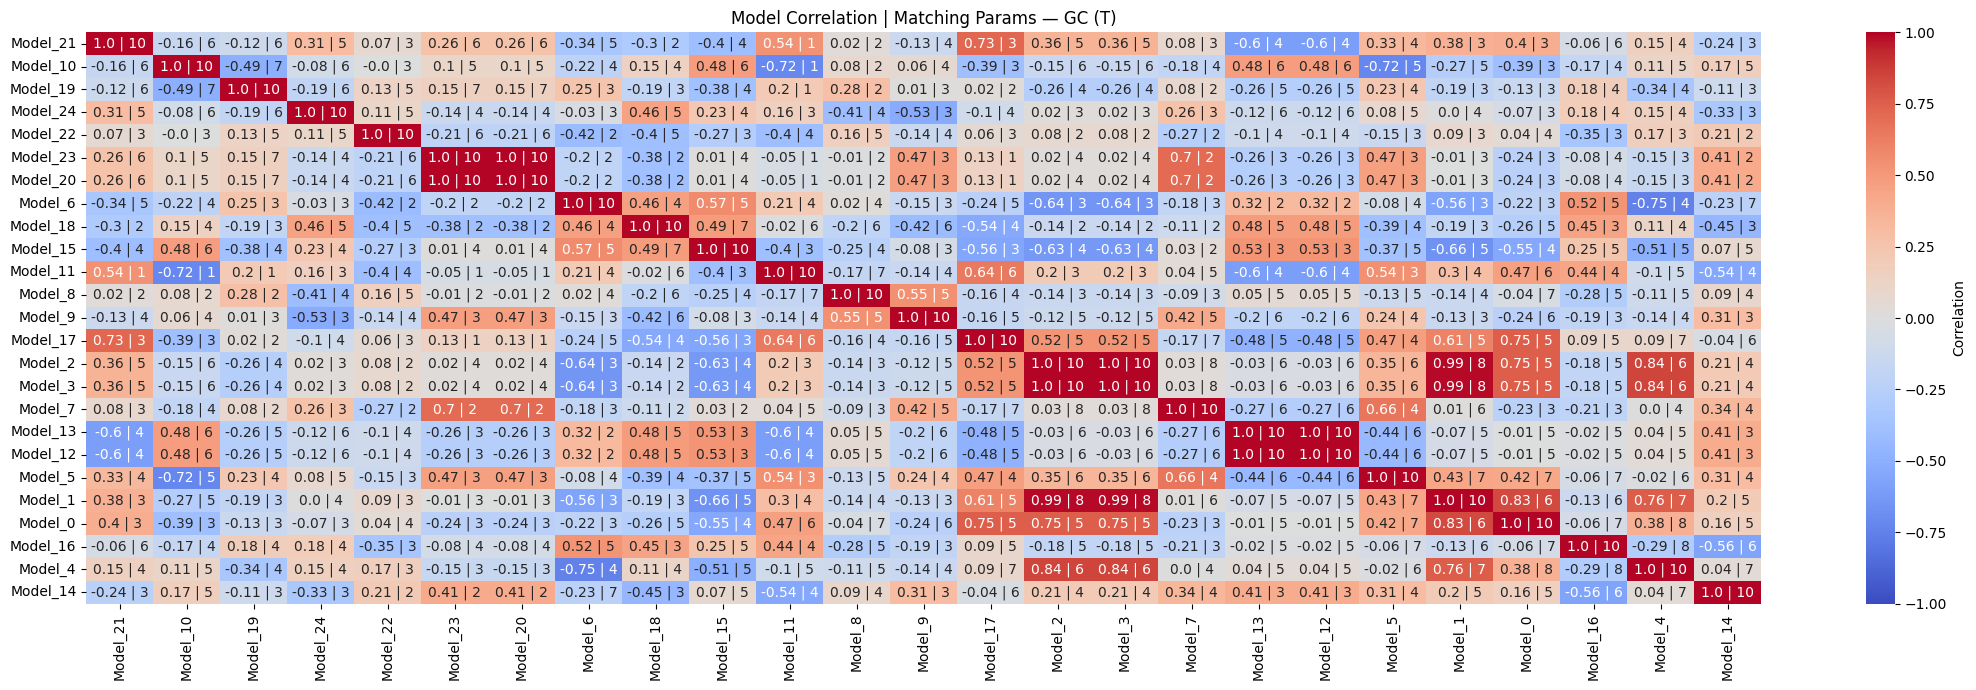

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_model_corr(master_df, machine="mac", set_type="V"):
    """
    Plots correlation and matching-parameter counts for models
    from a given machine ('mac' or 'gc') and set type ('V' or 'T'),
    using the param_int_Vue column as the unique model ID.
    """
    # Dynamic column names
    preds_col  = f"all_preds_{machine}_{set_type}"
    params_col = f"parameters_{machine}_{set_type}"
    id_col     = f"param_int_Vue_{machine}_{set_type}"  # unique model integer

    # Extract relevant rows
    block = master_df[[preds_col, params_col, id_col]].reset_index(drop=True)
    if block.empty:
        raise ValueError(f"No data found for machine '{machine}' and set '{set_type}'.")

    # 1. Flatten predictions
    all_preds_list = []
    for preds in block[preds_col]:
        flat = [p for fold in preds for p in fold]  # flatten folds
        all_preds_list.append(flat)

    labels = [f"Model_{int(mid)}" for mid in block[id_col]]

    # 2. Correlation matrix
    corr = np.corrcoef(all_preds_list)
    corr_df = pd.DataFrame(corr, index=labels, columns=labels)

    # 3. Matching parameter counts
    keys_to_check = [
        "learning_rate", "num_epochs", "batch_size", "lag",
        "num_layers", "input_size", "use_rolling_fixed_train_size",
        "hidden_size", "use_class_weighting", "use_dropout"
    ]
    params_list = block[params_col].tolist()
    n = len(params_list)
    match_counts = np.zeros((n, n), dtype=int)

    for i in range(n):
        for j in range(n):
            p1, p2 = params_list[i], params_list[j]
            if not isinstance(p1, dict) or not isinstance(p2, dict):
                continue
            match_counts[i, j] = sum(p1.get(k) == p2.get(k) for k in keys_to_check)

    match_df = pd.DataFrame(match_counts, index=labels, columns=labels)

    # 4. Annotated heatmap
    annot = corr_df.round(2).astype(str) + " | " + match_df.astype(str)

    plt.figure(figsize=(22, 7))
    sns.heatmap(
        corr_df,
        annot=annot,
        fmt="",
        cmap="coolwarm",
        vmin=-1, vmax=1,
        cbar_kws={'label': 'Correlation'}
    )
    plt.title(f"Model Correlation | Matching Params — {machine.upper()} ({set_type})")
    plt.tight_layout()
    plt.show()


# Example usage:
plot_model_corr(master_df, machine="gc", set_type="V")
# plot_model_corr(master_df, machine="mac", set_type="T")
plot_model_corr(master_df, machine="gc", set_type="T")


In [14]:
import numpy as np
from itertools import combinations
from collections import Counter

def get_model_groups_in_corr_range(master_df, machine, set_type, corr_range, group_size=2):
    """
    Find groups of models (size=group_size) whose pairwise correlations
    of predictions fall within [low, high).

    Args:
        master_df (pd.DataFrame): your merged DF.
        machine (str): 'mac' or 'gc'.
        set_type (str): 'V' or 'T'.
        corr_range (tuple): (low, high) inclusive/exclusive as [low, high).
        group_size (int): number of models per group (>=2).

    Returns:
        list[tuple]: list of tuples of model IDs (param_int_Vue_...) meeting the criterion.
    """
    assert group_size >= 2, "group_size must be >= 2"

    preds_col = f"all_preds_{machine}_{set_type}"
    id_col    = f"param_int_Vue_{machine}_{set_type}"

    # Keep only rows with predictions and an ID
    block = master_df.loc[master_df[preds_col].notna() & master_df[id_col].notna(), [id_col, preds_col]]

    # Flatten predictions per model id
    preds_by_id = {}
    for _, row in block.iterrows():
        mid = int(row[id_col])
        flat = [p for fold in row[preds_col] for p in fold]
        preds_by_id[mid] = np.asarray(flat, dtype=float)

    if not preds_by_id:
        return []

    # Handle potential unequal lengths robustly:
    lengths = [len(v) for v in preds_by_id.values()]
    modal_len = Counter(lengths).most_common(1)[0][0]
    # Keep only models with the modal length to ensure comparable correlations
    preds_by_id = {k: v for k, v in preds_by_id.items() if len(v) == modal_len}

    model_ids = sorted(preds_by_id.keys())
    if len(model_ids) < group_size:
        return []

    # Build data matrix (n_models, n_samples)
    data = np.vstack([preds_by_id[mid] for mid in model_ids])

    # Correlation matrix
    corr = np.corrcoef(data)

    low, high = corr_range

    groups = []
    idx_map = {i: mid for i, mid in enumerate(model_ids)}

    # Fast path for pairs
    if group_size == 2:
        for i in range(len(model_ids)):
            for j in range(i+1, len(model_ids)):
                c = corr[i, j]
                if not np.isnan(c) and (low <= c < high):
                    groups.append((idx_map[i], idx_map[j]))
        return groups

    # For k >= 3: check all combinations are within range
    for combo in combinations(range(len(model_ids)), group_size):
        ok = True
        for a, b in combinations(combo, 2):
            c = corr[a, b]
            if np.isnan(c) or not (low <= c < high):
                ok = False
                break
        if ok:
            groups.append(tuple(idx_map[i] for i in combo))

    return groups



In [15]:
#                                               VAL SET MAC 

import random


n_random = 10

#  ----------------- Groups of size 2

groups_2_neg01_00 = get_model_groups_in_corr_range(master_df, "mac", "V", (-0.1, 0.0), group_size=2) ; rand_groups_2_neg01_00 = random.sample(groups_2_neg01_00, n_random)
groups_2_00_02    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.0, 0.2), group_size=2) ; rand_groups_2_00_02 = random.sample(groups_2_00_02, n_random)
groups_2_02_04    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.2, 0.4), group_size=2) ; rand_groups_2_02_04 = random.sample(groups_2_02_04, n_random)
groups_2_04_07    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.4, 0.7), group_size=2) ; rand_groups_2_04_07 = random.sample(groups_2_04_07, n_random)

# ------------------ Groups of size 3

# groups_3_neg01_00 = get_model_groups_in_corr_range(master_df, "mac", "V", (-0.1, 0.0), group_size=3)
groups_3_00_02    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.0, 0.2), group_size=3) ; rand_groups_3_00_02 = random.sample(groups_3_00_02, n_random)
groups_3_02_04    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.2, 0.4), group_size=3) ; rand_groups_3_02_04 = random.sample(groups_3_02_04, n_random)
# groups_3_04_07    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.4, 0.7), group_size=3)

# ------------------ Groups of size 4

# groups_4_neg01_00 = get_model_groups_in_corr_range(master_df, "mac", "V", (-0.1, 0.0), group_size=4)
# groups_4_00_02    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.0, 0.2), group_size=4) ; rand_groups_4_00_02 = random.sample(groups_4_00_02, n_random)
# groups_4_02_04    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.2, 0.4), group_size=4)
# groups_4_04_07    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.4, 0.7), group_size=4)


# ------------------- CHECK 

print(len(groups_2_neg01_00))
print(len(groups_2_00_02))
print(len(groups_2_02_04))
print(len(groups_2_04_07))
print('----')
# print(len(groups_3_neg01_00))
print(len(groups_3_00_02))
print(len(groups_3_02_04))
# print(len(groups_3_04_07))
print('----')
# print(len(groups_4_neg01_00))
# print(len(groups_4_00_02))
# print(len(groups_4_02_04))
# print(len(groups_4_04_07))


#                                               VAL SET MAC 

# -------- Size 2 --------
pair_params_map_2_neg01_00 = {
    pair: [
        master_df.loc[master_df["param_int_Vue_mac_V"] == pair[0], "parameters_mac_V"].iloc[0],
        master_df.loc[master_df["param_int_Vue_mac_V"] == pair[1], "parameters_mac_V"].iloc[0]
    ]
    for pair in rand_groups_2_neg01_00
}

pair_params_map_2_00_02 = {
    pair: [
        master_df.loc[master_df["param_int_Vue_mac_V"] == pair[0], "parameters_mac_V"].iloc[0],
        master_df.loc[master_df["param_int_Vue_mac_V"] == pair[1], "parameters_mac_V"].iloc[0]
    ]
    for pair in rand_groups_2_00_02
}

pair_params_map_2_02_04 = {
    pair: [
        master_df.loc[master_df["param_int_Vue_mac_V"] == pair[0], "parameters_mac_V"].iloc[0],
        master_df.loc[master_df["param_int_Vue_mac_V"] == pair[1], "parameters_mac_V"].iloc[0]
    ]
    for pair in rand_groups_2_02_04
}

pair_params_map_2_04_07 = {
    pair: [
        master_df.loc[master_df["param_int_Vue_mac_V"] == pair[0], "parameters_mac_V"].iloc[0],
        master_df.loc[master_df["param_int_Vue_mac_V"] == pair[1], "parameters_mac_V"].iloc[0]
    ]
    for pair in rand_groups_2_04_07
}

# -------- Size 3 --------
pair_params_map_3_00_02 = {
    pair: [
        master_df.loc[master_df["param_int_Vue_mac_V"] == pair[0], "parameters_mac_V"].iloc[0],
        master_df.loc[master_df["param_int_Vue_mac_V"] == pair[1], "parameters_mac_V"].iloc[0],
        master_df.loc[master_df["param_int_Vue_mac_V"] == pair[2], "parameters_mac_V"].iloc[0]
    ]
    for pair in rand_groups_3_00_02
}

pair_params_map_3_02_04 = {
    pair: [
        master_df.loc[master_df["param_int_Vue_mac_V"] == pair[0], "parameters_mac_V"].iloc[0],
        master_df.loc[master_df["param_int_Vue_mac_V"] == pair[1], "parameters_mac_V"].iloc[0],
        master_df.loc[master_df["param_int_Vue_mac_V"] == pair[2], "parameters_mac_V"].iloc[0]
    ]
    for pair in rand_groups_3_02_04
}

# # -------- Size 4 --------
# pair_params_map_4_00_02 = {
#     pair: [
#         master_df.loc[master_df["param_int_Vue_mac_V"] == pair[0], "parameters_mac_V"].iloc[0],
#         master_df.loc[master_df["param_int_Vue_mac_V"] == pair[1], "parameters_mac_V"].iloc[0],
#         master_df.loc[master_df["param_int_Vue_mac_V"] == pair[2], "parameters_mac_V"].iloc[0],
#         master_df.loc[master_df["param_int_Vue_mac_V"] == pair[3], "parameters_mac_V"].iloc[0]
#     ]
#     for pair in rand_groups_4_00_02
# }



#               SELECTIVE_ENSEMBLE_ALL_AGREE VAL SET VAL SET VAL SET VAL SET 

import pickle

ensemble_config = {
    "pair_params_map_2_neg01_00": pair_params_map_2_neg01_00,
    "pair_params_map_2_00_02": pair_params_map_2_00_02,
    "pair_params_map_2_02_04": pair_params_map_2_02_04,
    "pair_params_map_2_04_07": pair_params_map_2_04_07,
    "pair_params_map_3_00_02": pair_params_map_3_00_02,
    "pair_params_map_3_02_04": pair_params_map_3_02_04,
    # "pair_params_map_4_00_02": pair_params_map_4_00_02
}





38
96
65
18
----
72
28
----


In [16]:
from Results_Dists_V_2 import *


In [17]:
# Create pair parameter maps using the function
pair_params_map_2_neg01_00 = create_pair_params_map(rand_groups_2_neg01_00, master_df, num_models=2, data_type="V")
pair_params_map_2_00_02 = create_pair_params_map(rand_groups_2_00_02, master_df, num_models=2, data_type="V")
pair_params_map_2_02_04 = create_pair_params_map(rand_groups_2_02_04, master_df, num_models=2, data_type="V")
pair_params_map_2_04_07 = create_pair_params_map(rand_groups_2_04_07, master_df, num_models=2, data_type="V")


pair_params_map_3_00_02 = create_pair_params_map(rand_groups_3_00_02, master_df, num_models=3, data_type="V")
pair_params_map_3_02_04 = create_pair_params_map(rand_groups_3_02_04, master_df, num_models=3, data_type="V")



before set: [-0.022367913613575152, -0.1523234889382873, -0.10390349379765573, -0.1523234889382873, -0.0953469962177852, 0.14319526627218937, -0.1523234889382873, 0.10238210986874097, -0.022367913613575152, -0.022367913613575152, -0.10390349379765573, -0.022367913613575152, -0.022367913613575152, -0.1523234889382873, -0.051506024096385494, -0.1523234889382873, -0.022367913613575152, -0.022367913613575152, -0.022367913613575152, -0.022367913613575152, -0.1523234889382873, -0.1523234889382873]
after set: {-0.022367913613575152, -0.1523234889382873, 0.14319526627218937, -0.0953469962177852, -0.10390349379765573, 0.10238210986874097, -0.051506024096385494}
before set: [-0.051506024096385494, -0.10390349379765573, -0.0953469962177852, -0.022367913613575152, -0.1523234889382873, -0.0953469962177852, -0.022367913613575152, -0.022367913613575152, -0.1523234889382873, -0.10390349379765573, -0.022367913613575152, -0.051506024096385494, -0.1523234889382873, -0.022367913613575152, -0.1039034937976

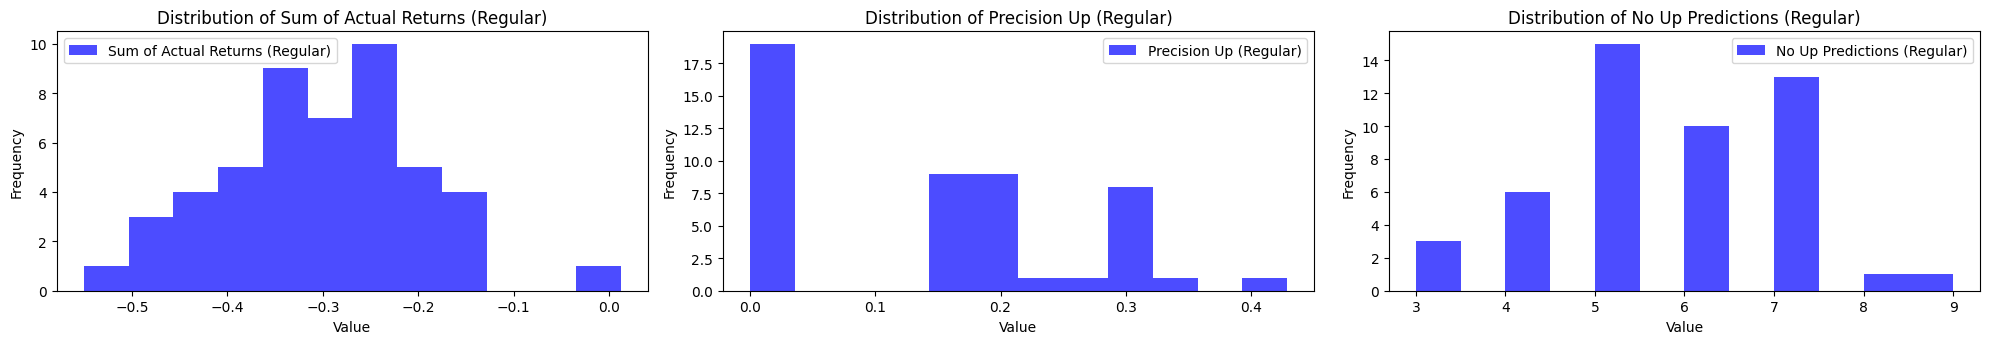

In [19]:
groups_2_neg01_00 = get_model_groups_in_corr_range(master_df, "mac", "V", (-0.1, 0.0), group_size=2) ; rand_groups_2_neg01_00 = random.sample(groups_2_neg01_00, n_random)
groups_2_00_02    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.0, 0.2), group_size=2) ; rand_groups_2_00_02 = random.sample(groups_2_00_02, n_random)
groups_2_02_04    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.2, 0.4), group_size=2) ; rand_groups_2_02_04 = random.sample(groups_2_02_04, n_random)
groups_2_04_07    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.4, 0.7), group_size=2) ; rand_groups_2_04_07 = random.sample(groups_2_04_07, n_random)

# ------------------ Groups of size 3

# groups_3_neg01_00 = get_model_groups_in_corr_range(master_df, "mac", "V", (-0.1, 0.0), group_size=3)
groups_3_00_02    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.0, 0.2), group_size=3) ; rand_groups_3_00_02 = random.sample(groups_3_00_02, n_random)
groups_3_02_04    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.2, 0.4), group_size=3) ; rand_groups_3_02_04 = random.sample(groups_3_02_04, n_random)
# groups_3_04_07    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.4, 0.7), group_size=3)


# Define your groups configuration
groups_config = [
    ("mac", (-0.1, 0.0), 2),
    ("mac", (0.0, 0.2), 2),
    ("mac", (0.2, 0.4), 2),
    ("mac", (0.4, 0.7), 2),

    ("mac", (0.0, 0.2), 3),
    ("mac", (0.2, 0.4), 3)
]


number_realizations = 50

all_results_regular = []


# random_seeds_seed = 444
# random.seed(random_seeds_seed)


sample_size = number_realizations
seeds = random.sample(range(1, 100000), sample_size)

for i, seed_ in zip(range(1, number_realizations), seeds):

    results = process_func_PLUS_return_analytics(
    master_df=master_df,
    groups_config=groups_config,
    data_type_corr_groups_creation="V",
    data_type_ensemble="T",
    use_threshold_data=False,
    seed=None,
    no_maps_per_group=10 , filter_outliers=True)

    all_results_regular.append(results)

all_groups_prec_up_regular = []
all_groups_total_return_regular = []
no_up_preds_per_group_regular = []



        # "Sum of HOD Actual Returns for Up Predictions": HOD_sum_actuals_ups,
        # "Sum of UCO Actual Returns for Up Predictions": UCO_sum_actuals_ups,
        # "Sum of HUC Actual Returns for Up Predictions": HUC_sum_actuals_ups,

for seed_res in all_results_regular:
    #first set of plots 
    all_groups_total_return_regular.append(seed_res["summary"]["Sum of Actual Returns for Up Predictions"])
    all_groups_prec_up_regular.append(seed_res["summary"]['Prec Up'])
    no_up_preds_per_group_regular.append(seed_res["summary"]['Total Up Predictions'])

    


import matplotlib.pyplot as plt

# List of variable names and titles
metrics = [

    (all_groups_total_return_regular, 'Sum of Actual Returns (Regular)', 'blue'),
    (all_groups_prec_up_regular, 'Precision Up (Regular)', 'blue'),
    (no_up_preds_per_group_regular, 'No Up Predictions (Regular)', 'blue'),

    # (HOD_all_groups_total_return_regular, 'HOD Sum', 'green'),
    # (UCO_all_groups_total_return_regular, 'UCO Sum', 'orange'),
    # (HUC_all_groups_total_return_regular, 'HUC Sum', 'red'),
    # (CRUD_all_groups_total_return_regular, 'CRUD Sum', 'purple'),
    # (USO_all_groups_total_return_regular, 'USO Sum', 'brown'),

    # (HOD_all_groups_total_return_threshold, 'HOD Sum', 'green'),
    # (UCO_all_groups_total_return_threshold, 'UCO Sum', 'orange'),
    # (HUC_all_groups_total_return_threshold, 'HUC Sum', 'red'),
    # (CRUD_all_groups_total_return_threshold, 'CRUD Sum', 'purple'),
    # (USO_all_groups_total_return_threshold, 'USO Sum', 'brown'),

]

plt.figure(figsize=(20, 19))

for i, (var_name, title, color) in enumerate(metrics, 1):
    plt.subplot(6, 3, i)
    data = var_name  # Get the variable by name
    plt.hist(data, bins=12, alpha=0.7, label=title, color=color)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {title}')
    plt.legend()

plt.tight_layout()
plt.show()






In [ ]:
results

{'group_results': {'pair_2_neg01_00': ['None - 0 (8, 19) - 0 - Correct: 0 - [] - HOD vals: []                     - UCO vals: [] - HUC vals: [] - CRUD vals: [] - USO vals: []',
   'None - 0 (2, 8) - 0 - Correct: 0 - [] - HOD vals: []                     - UCO vals: [] - HUC vals: [] - CRUD vals: [] - USO vals: []',
   'None - 0 (11, 17) - 0 - Correct: 0 - [] - HOD vals: []                     - UCO vals: [] - HUC vals: [] - CRUD vals: [] - USO vals: []',
   'None - None (6, 7) - 0 - Correct: 0 - [] - HOD vals: []                     - UCO vals: [] - HUC vals: [] - CRUD vals: [] - USO vals: []',
   '100.0 - 20.0 (2, 6) - 1 - Correct: 1 - [-0.1523234889382873] - HOD vals: [np.float64(0.28744769874477005)]                     - UCO vals: [np.float64(-0.28960608006850785)] - HUC vals: [np.float64(-0.1429220425222606)] - CRUD vals: [np.float64(-0.13302843507655593)] - USO vals: [np.float64(-0.14427860696517414)]',
   'None - 0 (8, 21) - 0 - Correct: 0 - [] - HOD vals: []                    

In [ ]:
#                                               VAL SET GC 
#                                               VAL SET GC 


import random

random.seed(42)


n_random = 10

#  ----------------- Groups of size 2

groups_2_neg01_00 = get_model_groups_in_corr_range(master_df, "gc", "V", (-0.1, 0.0), group_size=2) 
groups_2_00_02    = get_model_groups_in_corr_range(master_df, "gc", "V", (0.0, 0.2), group_size=2) 
groups_2_02_04    = get_model_groups_in_corr_range(master_df, "gc", "V", (0.2, 0.4), group_size=2) 
groups_2_04_07    = get_model_groups_in_corr_range(master_df, "gc", "V", (0.4, 0.7), group_size=2) 

# ------------------ Groups of size 3

# groups_3_neg01_00 = get_model_groups_in_corr_range(master_df, "gc", "V", (-0.1, 0.0), group_size=3)
groups_3_00_02    = get_model_groups_in_corr_range(master_df, "gc", "V", (0.0, 0.2), group_size=3) 
groups_3_02_04    = get_model_groups_in_corr_range(master_df, "gc", "V", (0.2, 0.4), group_size=3) 
groups_3_04_07    = get_model_groups_in_corr_range(master_df, "gc", "V", (0.4, 0.7), group_size=3)

# ------------------ Groups of size 4

# groups_4_neg01_00 = get_model_groups_in_corr_range(master_df, "gc", "V", (-0.1, 0.0), group_size=4)
# groups_4_00_02    = get_model_groups_in_corr_range(master_df, "gc", "V", (0.0, 0.2), group_size=4) 
groups_4_02_04    = get_model_groups_in_corr_range(master_df, "gc", "V", (0.2, 0.4), group_size=4)
groups_4_04_07    = get_model_groups_in_corr_range(master_df, "gc", "V", (0.4, 0.7), group_size=4)

# Random sampling for non-commented groups
rand_groups_2_neg01_00 = random.sample(groups_2_neg01_00, 10)
rand_groups_2_00_02 = random.sample(groups_2_00_02, 10)
rand_groups_2_02_04 = random.sample(groups_2_02_04, 10)
rand_groups_2_04_07 = random.sample(groups_2_04_07, 10)
rand_groups_3_00_02 = random.sample(groups_3_00_02, 10)
rand_groups_3_02_04 = random.sample(groups_3_02_04, 10)
rand_groups_3_04_07 = random.sample(groups_3_04_07, 10)
rand_groups_4_02_04 = random.sample(groups_4_02_04, 10)
rand_groups_4_04_07 = random.sample(groups_4_04_07, 10)



# ------------------- CHECK 

print(len(groups_2_neg01_00))
print(len(groups_2_00_02))
print(len(groups_2_02_04))
print(len(groups_2_04_07))
print('----')
# print(len(groups_3_neg01_00))
print(len(groups_3_00_02))
print(len(groups_3_02_04))
print(len(groups_3_04_07))
print('----')
# print(len(groups_4_neg01_00))
# print(len(groups_4_00_02))
print(len(groups_4_02_04))
print(len(groups_4_04_07))




# -------- Size 2 --------
pair_params_map_2_neg01_00 = {
    pair: [
        master_df.loc[master_df["param_int_Vue_gc_V"] == pair[0], "parameters_gc_V"].iloc[0],
        master_df.loc[master_df["param_int_Vue_gc_V"] == pair[1], "parameters_gc_V"].iloc[0]
    ]
    for pair in rand_groups_2_neg01_00
}

pair_params_map_2_00_02 = {
    pair: [
        master_df.loc[master_df["param_int_Vue_gc_V"] == pair[0], "parameters_gc_V"].iloc[0],
        master_df.loc[master_df["param_int_Vue_gc_V"] == pair[1], "parameters_gc_V"].iloc[0]
    ]
    for pair in rand_groups_2_00_02
}

pair_params_map_2_02_04 = {
    pair: [
        master_df.loc[master_df["param_int_Vue_gc_V"] == pair[0], "parameters_gc_V"].iloc[0],
        master_df.loc[master_df["param_int_Vue_gc_V"] == pair[1], "parameters_gc_V"].iloc[0]
    ]
    for pair in rand_groups_2_02_04
}

pair_params_map_2_04_07 = {
    pair: [
        master_df.loc[master_df["param_int_Vue_gc_V"] == pair[0], "parameters_gc_V"].iloc[0],
        master_df.loc[master_df["param_int_Vue_gc_V"] == pair[1], "parameters_gc_V"].iloc[0]
    ]
    for pair in rand_groups_2_04_07
}

# -------- Size 3 --------
pair_params_map_3_00_02 = {
    pair: [
        master_df.loc[master_df["param_int_Vue_gc_V"] == pair[0], "parameters_gc_V"].iloc[0],
        master_df.loc[master_df["param_int_Vue_gc_V"] == pair[1], "parameters_gc_V"].iloc[0],
        master_df.loc[master_df["param_int_Vue_gc_V"] == pair[2], "parameters_gc_V"].iloc[0]
    ]
    for pair in rand_groups_3_00_02
}

pair_params_map_3_02_04 = {
    pair: [
        master_df.loc[master_df["param_int_Vue_gc_V"] == pair[0], "parameters_gc_V"].iloc[0],
        master_df.loc[master_df["param_int_Vue_gc_V"] == pair[1], "parameters_gc_V"].iloc[0],
        master_df.loc[master_df["param_int_Vue_gc_V"] == pair[2], "parameters_gc_V"].iloc[0]
    ]
    for pair in rand_groups_3_02_04
}

pair_params_map_3_04_07 = {
    pair: [
        master_df.loc[master_df["param_int_Vue_gc_V"] == pair[0], "parameters_gc_V"].iloc[0],
        master_df.loc[master_df["param_int_Vue_gc_V"] == pair[1], "parameters_gc_V"].iloc[0],
        master_df.loc[master_df["param_int_Vue_gc_V"] == pair[2], "parameters_gc_V"].iloc[0]
    ]
    for pair in rand_groups_3_04_07
}

# -------- Size 4 --------
pair_params_map_4_02_04 = {
    pair: [
        master_df.loc[master_df["param_int_Vue_gc_V"] == pair[0], "parameters_gc_V"].iloc[0],
        master_df.loc[master_df["param_int_Vue_gc_V"] == pair[1], "parameters_gc_V"].iloc[0],
        master_df.loc[master_df["param_int_Vue_gc_V"] == pair[2], "parameters_gc_V"].iloc[0],
        master_df.loc[master_df["param_int_Vue_gc_V"] == pair[3], "parameters_gc_V"].iloc[0]
    ]
    for pair in rand_groups_4_02_04
}

pair_params_map_4_04_07 = {
    pair: [
        master_df.loc[master_df["param_int_Vue_gc_V"] == pair[0], "parameters_gc_V"].iloc[0],
        master_df.loc[master_df["param_int_Vue_gc_V"] == pair[1], "parameters_gc_V"].iloc[0],
        master_df.loc[master_df["param_int_Vue_gc_V"] == pair[2], "parameters_gc_V"].iloc[0],
        master_df.loc[master_df["param_int_Vue_gc_V"] == pair[3], "parameters_gc_V"].iloc[0]
    ]
    for pair in rand_groups_4_04_07
}






38
67
102
56
----
30
76
44
----
15
23


In [ ]:
pair_variables_list = [
    pair_params_map_2_neg01_00,
    pair_params_map_2_00_02,
    pair_params_map_2_02_04,
    pair_params_map_2_04_07,
    pair_params_map_3_00_02,
    pair_params_map_3_02_04,
    pair_params_map_3_04_07,
    pair_params_map_4_02_04,
    pair_params_map_4_04_07
]


for pair_params in pair_variables_list:

    for list in pair_params.values():

        for params in list:

            params["val_set_fraction"] = 0.05
            params["num_folds"] = 4
            params["end_value_train_set_fraction"] = 0.95




all_pair_maps = {
    'pair_params_map_2_neg01_00' : pair_params_map_2_neg01_00 ,
    'pair_params_map_2_00_02' : pair_params_map_2_00_02 ,
    'pair_params_map_2_02_04' : pair_params_map_2_02_04 ,
    'pair_params_map_2_04_07' : pair_params_map_2_04_07 ,
    'pair_params_map_3_00_02' : pair_params_map_3_00_02 ,
    'pair_params_map_3_02_04' : pair_params_map_3_02_04 ,
    'pair_params_map_3_04_07' : pair_params_map_3_04_07 ,
    'pair_params_map_4_02_04' : pair_params_map_4_02_04 , 
    'pair_params_map_4_04_07' : pair_params_map_4_04_07
}

# Save to pickle
with open("pair_params_maps_gc_T.pkl", "wb") as f:
    pickle.dump(all_pair_maps, f)

print("✅ Saved all pair maps to pair_params_maps.pkl")



✅ Saved all pair maps to pair_params_maps.pkl


---
# Part 3 : Analysis
---

In [ ]:
import json 

all_pair_maps = [
    "pair_params_map_2_neg01_00",
    "pair_params_map_2_00_02" ,
    "pair_params_map_2_02_04" ,
    "pair_params_map_2_04_07",
    "pair_params_map_3_00_02" ,
    "pair_params_map_3_02_04" ,
    "pair_params_map_4_00_02" 
]


corr_res_MAC_V = []

for name in all_pair_maps:
    with open(f'/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/Top 25 GS Models V_1 Ensemble Results/results_MAC_Vset_pair_params/results_MAC_Vset_{name}.json') as file:
        data = json.load(file)
        corr_res_MAC_V.append(data)

# for i in corr_res_MAC_V:
#     print(i)

for i in corr_res_MAC_V[:len(corr_res_MAC_V) ]:
    print('-----')
    for j in i:
        
        print(j["cv_sets"]["overall_metrics"]["precision_up"] , '-' ,j["cv_sets"]["overall_metrics"]["recall_up"] ,j["combo_numbers"])


# corr_res_MAC_V


-----
0.0 - 0.0 [6, 19]
0.0 - 0.0 [6, 11]
None - 0 [11, 18]
None - 0 [12, 22]
100.0 - 20.0 [0, 14]
None - 0 [5, 10]
None - 0 [11, 17]
100.0 - 50.0 [3, 8]
None - 0 [13, 22]
0.0 - 0.0 [5, 6]
-----
None - 0 [3, 15]
100.0 - 16.666666666666664 [14, 21]
None - 0 [3, 12]
100.0 - 28.57142857142857 [0, 16]
100.0 - 25.0 [3, 4]
100.0 - 16.666666666666664 [15, 23]
None - 0 [13, 16]
100.0 - 40.0 [2, 19]
None - 0 [9, 13]
100.0 - 40.0 [1, 5]
-----
100.0 - 40.0 [2, 11]
50.0 - 16.666666666666664 [0, 4]
None - 0 [13, 21]
None - 0 [12, 19]
66.66666666666666 - 40.0 [2, 16]
100.0 - 33.33333333333333 [8, 23]
100.0 - 28.57142857142857 [5, 7]
None - 0 [11, 15]
100.0 - 20.0 [6, 23]
0.0 - 0.0 [5, 24]
-----
50.0 - 28.57142857142857 [0, 5]
66.66666666666666 - 28.57142857142857 [0, 11]
100.0 - 28.57142857142857 [7, 16]
50.0 - 14.285714285714285 [4, 19]
66.66666666666666 - 25.0 [5, 11]
66.66666666666666 - 28.57142857142857 [0, 19]
50.0 - 16.666666666666664 [9, 19]
75.0 - 50.0 [3, 7]
None - 0 [10, 15]
75.0 - 50.0 [2

In [ ]:
import json 


all_pair_maps = [
    'pair_params_map_2_neg01_00',
    'pair_params_map_2_00_02',
    'pair_params_map_2_02_04',
    'pair_params_map_2_04_07',
    'pair_params_map_3_00_02',
    'pair_params_map_3_02_04',
    'pair_params_map_3_04_07',
    'pair_params_map_4_02_04',
    'pair_params_map_4_04_07'
]

corr_res_MAC_V = []

for name in all_pair_maps:
    with open(f'/Users/cs/Desktop/Top_25_GS_Ensemble_Results/results_GC_Tset_pair_params/results_GC_Tset_{name}.json') as file:
        data = json.load(file)
        corr_res_MAC_V.append(data)

# for i in corr_res_MAC_V:
#     print(i)

for i in corr_res_MAC_V[:len(corr_res_MAC_V) ]:
    print('-----')
    for j in i:
        
        print(j["cv_sets"]["overall_metrics"]["precision_up"] , '-' ,j["cv_sets"]["overall_metrics"]["recall_up"] ,j["combo_numbers"])


# corr_res_MAC_V


FileNotFoundError: [Errno 2] No such file or directory: '/Users/cs/Desktop/Top_25_GS_Ensemble_Results/results_GC_Tset_pair_params/results_GC_Tset_pair_params_map_2_neg01_00.json'

In [ ]:
import json 



with open(f'/Users/cs/Desktop/Top_25_GS_Ensemble_Results/results_MAC_Tset_pair_params_ALL.json') as file:
    data = json.load(file)

import numpy as np 
# for i in corr_res_MAC_V:
#     print(i)


for i in data:

    print('-----')
    for j in i:


        flatten_preds = [j for part in j["all_preds"] for j in part]
        flatten_raw_actuals = [j for part in j["raw_actuals"] for j in part]

        p_ups = sum(i > .5 for i in flatten_preds if isinstance(i,int))

        # up_vals_predicted = [j for part in j["all_actuals"] for j in part if not isinstance(j , str) and j > 0.5 ]

        up_vals_predicted_raw_val = []
        for p,a in zip(flatten_preds , flatten_raw_actuals):
            if not isinstance(p , str ) and p > 0.5:
                up_vals_predicted_raw_val.append(a)


        
        print(j["cv_sets"]["overall_metrics"]["precision_up"] , '-' ,j["cv_sets"]["overall_metrics"]["recall_up"] 
              ,j["combo_numbers"], '-', p_ups , '-' , up_vals_predicted_raw_val)





-----
None - 0 [13, 22] - 0 - []
100.0 - 33.33333333333333 [10, 18] - 1 - [-0.10390349379765573]
100.0 - 50.0 [3, 6] - 1 - [-0.1523234889382873]
None - 0 [4, 24] - 0 - []
None - 0 [11, 17] - 0 - []
None - 0 [6, 8] - 0 - []
0.0 - 0.0 [16, 19] - 1 - [-0.022367913613575152]
None - 0 [8, 21] - 0 - []
None - 0 [16, 23] - 0 - []
100.0 - 33.33333333333333 [0, 22] - 1 - [-0.1523234889382873]
-----
None - 0 [12, 16] - 0 - []
50.0 - 25.0 [0, 24] - 2 - [0.14319526627218937, -0.1523234889382873]
50.0 - 25.0 [0, 16] - 2 - [-0.022367913613575152, -0.1523234889382873]
None - 0 [4, 5] - 0 - []
None - 0 [2, 4] - 0 - []
100.0 - 66.66666666666666 [6, 22] - 2 - [-0.07675194660734153, -0.1523234889382873]
None - 0 [11, 14] - 0 - []
None - 0 [5, 13] - 0 - []
50.0 - 33.33333333333333 [10, 24] - 2 - [0.10238210986874097, -0.1523234889382873]
None - 0 [3, 23] - 0 - []
-----
None - 0 [0, 15] - 0 - []
100.0 - 20.0 [4, 18] - 1 - [-0.10390349379765573]
50.0 - 25.0 [9, 11] - 2 - [-0.022367913613575152, -0.095346996

---
# Part 4: GS Best Results Distribution Discovery 
---

In [ ]:
import pandas as pd
import pickle
import random
import numpy as np
import os
import itertools
from joblib import Parallel, delayed , parallel_backend
from collections import defaultdict
import math
import torch.nn as nn




from Equations_Run_Combo_V_2 import (


    run_combo,
    LSTM,
    TimeSeriesDataset,
    format_to_tensor,
    train_one_epoch,
    validate_one_epoch,
    evaluate_binary_0_1,
    evaluate_signed_neg1_1 ,
)


from Equations_Ensembles_Dist import (

    evaluate_binary_0_1_selective_ensemble , distribution_discovery , avg_ensemble , selective_ensemble_all_agree
    , selective_ensemble_threshold_agreement , selective_ensemble_majority_vote

)


: 

In [ ]:
import json
import numpy as np
import copy


# with open(f'/Users/cs/Desktop/Incomplete Results/full_results_chunk_1_25_CHUNKS_8fold_05NEG__VERSION_4__GSresults.json', 'r') as f:
#     results = json.load(f)



with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/results_8fold_05NEG_best_models_GC_V_overtall_metrics_FIX.json' , 'r') as f_json:
   results3 =  json.load(f_json)


scored_results = []
for entry in results3:
    avg = entry['cv_sets'].get('overall_metrics', {})
    acc = avg.get('accuracy') or 0.0
    prec_up = avg.get('precision_up') or 0.0
    recall_up = avg.get('recall_up') or 0.0

    total_score = acc  # or add prec_up, etc.
    
    sets = entry["cv_sets"]
    acc_3 = sets.get("set_3", {}).get("accuracy")
    acc_5 = sets.get("set_5", {}).get("accuracy")
    acc_6 = sets.get("set_6", {}).get("accuracy")

    # if acc_3 == (100.0  ) and acc_5 == (100.0 or 66.66666666666666 ) and acc_6 == (100.0  ) and recall_up > 20 and prec_up > 70:
    # if acc_3 == (100.0) and acc_5 == (100.0) and acc_6 == (100.0) and recall_up > 20 and prec_up > 80:
    if recall_up > 20 and prec_up > 75:

        scored_results.append((total_score, entry))

# Step 2: Sort by score descending
scored_results.sort(reverse=True, key=lambda x: x[0])

# Step 3: Extract top 10 entries
top = scored_results[:70]

for i, j in top:
    print(j["combo_number"], '<--->' , j["cv_sets"]["overall_metrics"] , '<---->' , j["parameters"] )

# Step 4: Extract the parameter combos
combos = [j["parameters"] for i, j in top]


combos_test_param = []

for i in combos:
    i_copy = copy.deepcopy(i)
    i_copy["val_set_fraction"] = 0.05
    i_copy["num_folds"] = 4
    i_copy["end_value_train_set_fraction"] = 0.95
    combos_test_param.append(i_copy)


# len(top)
len(combos)




# #### ----------------------                 RUN COMBOS
# with parallel_backend("loky", n_jobs=-1):
#     results = Parallel()(
#         delayed(run_combo)(0, combo, i, use_print_acc_vs_pred=False)
        
#         for i, (combo) in enumerate(combos_test_param)
#     )

# res , w = zip(*results)

# import copy

# metrics_c = copy.deepcopy(res)

# for m in metrics_c:
#     # Convert all_preds from arrays → lists of lists
#     m["all_preds"] = [pred.tolist() if hasattr(pred, "tolist") else pred for pred in m["all_preds"]]
#     m["all_actuals"] = [act.tolist() if hasattr(act, "tolist") else act for act in m["all_actuals"]]
#     m["raw_actuals"] = [act.tolist() if hasattr(act, "tolist") else act for act in m["raw_actuals"]]
    

# res_name = f"/Users/cs/Desktop/results_8fold_05NEG_preds_best_models_GC_V_2.json"
# # # file_weights = f"/Users/cs/Desktop/full_results_chunk_{chunk_to_run + 1}_{n_chunks}_WEIGHTS_8fold_05NEG__VERSION_2.pt"

# with open(res_name, "w") as f_json:
#     json.dump(metrics_c, f_json, indent=2)



len(results3)


1 <---> {'accuracy': 91.66666666666666, 'precision_up': 87.5, 'recall_up': 87.5, 'precision_down': 93.75, 'recall_down': 93.75} <----> {'learning_rate': 0.05, 'num_epochs': 700, 'batch_size': 10, 'use_bidirectional': False, 'lag': 3, 'input_size': 12, 'hidden_size': 12, 'num_layers': 2, 'use_monthly_dfs_only': True, 'use_binary_0_1': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': True, 'use_class_weighting': False, 'is_deterministic': True, 'seed_num': 42, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_custom_neg': True, 'use_binary_0_1_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.85, 'val_set_fraction': 0.1, 'num_folds': 8, 'POS_weight_multiplier': 0.1, 'use_rolling_fixed_train_size': False, 'use_existing_initial_weights': False

70

In [ ]:
# c = {'learning_rate': 0.05, 'num_epochs': 150, 'batch_size': 50, 'use_bidirectional': False, 'lag': 3, 'input_size': 12, 'hidden_size': 55, 'num_layers': 1, 'use_monthly_dfs_only': True, 'use_binary_0_1': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': False, 'use_class_weighting': False, 'is_deterministic': True, 'seed_num': 42, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_custom_neg': True, 'use_binary_0_1_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.85, 'val_set_fraction': 0.1, 'num_folds': 8, 'POS_weight_multiplier': 0.7, 'use_rolling_fixed_train_size': False, 'use_existing_initial_weights': False, 'state_dict': None}

# res = distribution_discovery(c, combo_index = 0 , number_of_seeds = 40)


#### ----------------------                 RUN COMBOS
with parallel_backend("loky", n_jobs=3):
    results = Parallel()(
        delayed(distribution_discovery)(c, combo_index = i , number_of_seeds = 60)
        
        for i, c in enumerate(combos)
    )




****************** STARTED RUN FOR COMBO INDEX 1
****************** STARTED RUN FOR COMBO INDEX 0
****************** STARTED RUN FOR COMBO INDEX 2
--- Running Combo 1 ---Parameters: {'learning_rate': 0.05, 'num_epochs': 70, 'batch_size': 50, 'use_bidirectional': False, 'lag': 3, 'input_size': 12, 'hidden_size': 55, 'num_layers': 1, 'use_monthly_dfs_only': True, 'use_binary_0_1': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': True, 'use_class_weighting': False, 'is_deterministic': True, 'seed_num': 9906, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_custom_neg': True, 'use_binary_0_1_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.85, 'val_set_fraction': 0.1, 'num_folds': 8, 'POS_weight_multiplier': 0.7, 'use_rolling_fixed_train_siz

: 

: 

: 

In [ ]:
import json

file_json_metrics = f"/Users/cs/Desktop/top_combos_dist_discovcery_25_combos.json"


with open(file_json_metrics, "w") as f_json:
    json.dump(results, f_json, indent=2)





In [ ]:
import json

with open("/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/top_combos_dist_discovcery_25_combos_MAC.json") as f:
    results = json.load(f)


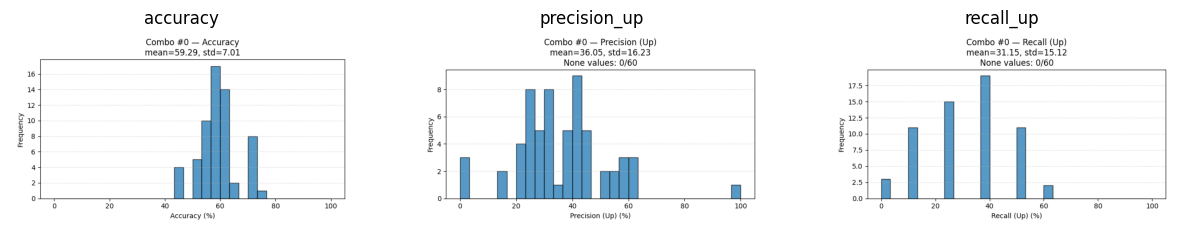

0.1


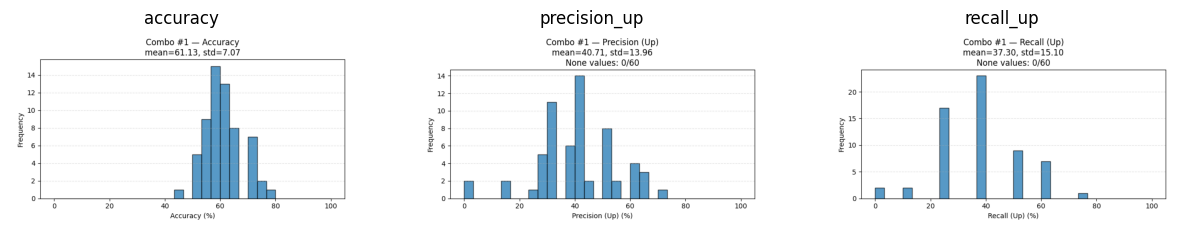

0.7


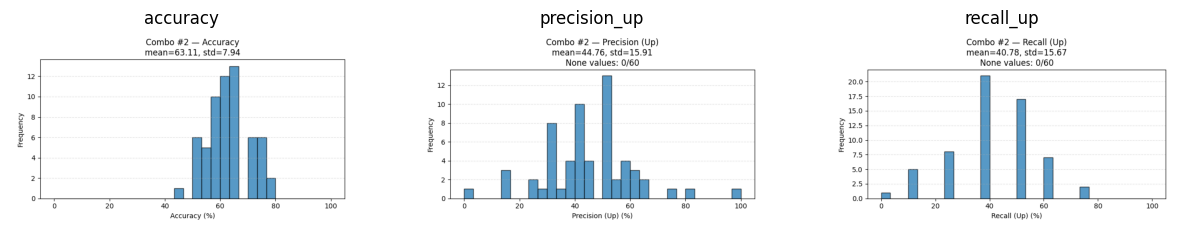

0.7


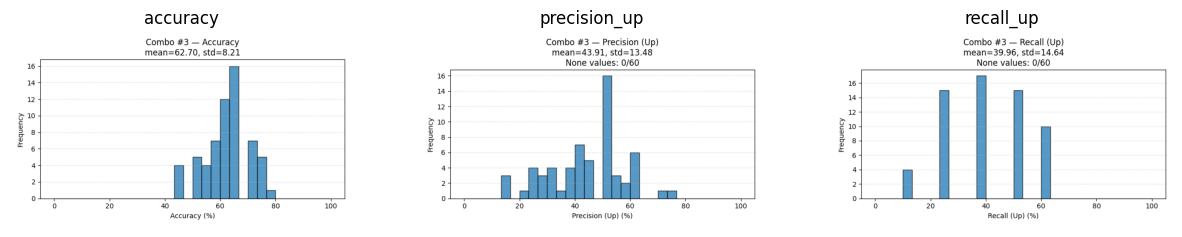

1


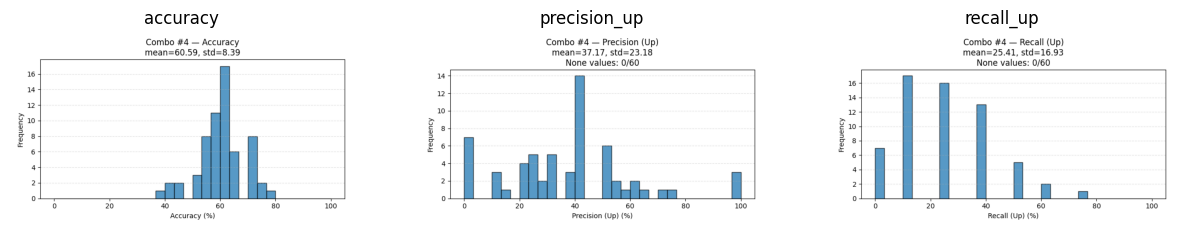

0.1


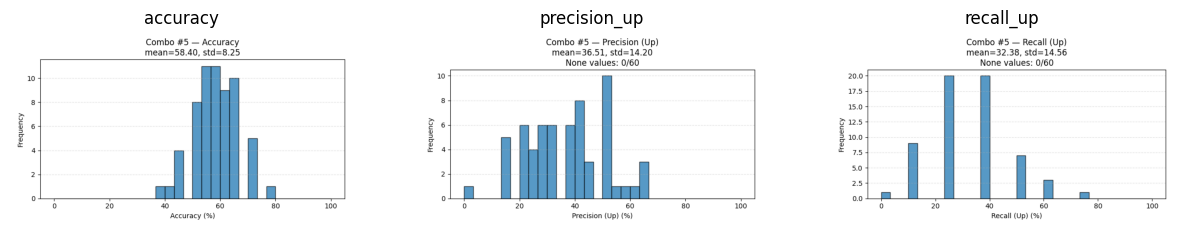

1


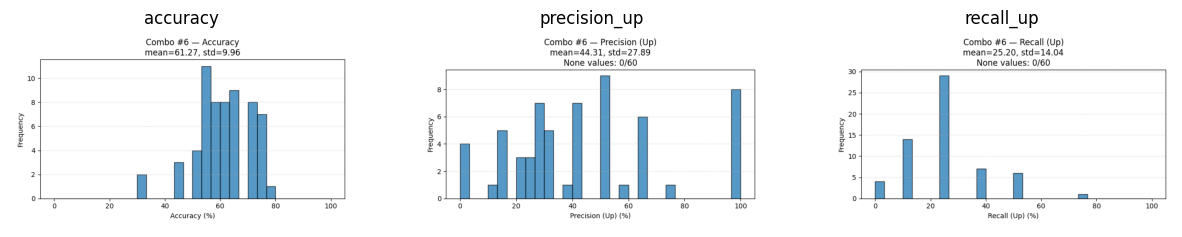

0.7


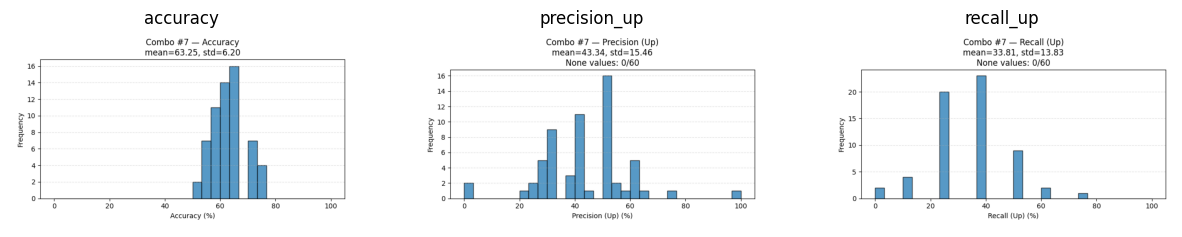

0.1


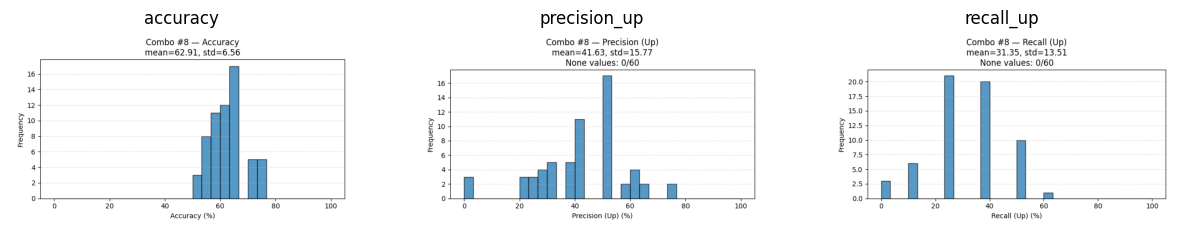

0.1


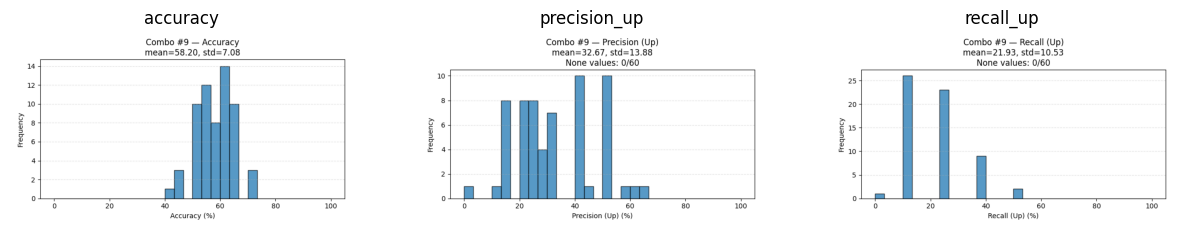

1.3


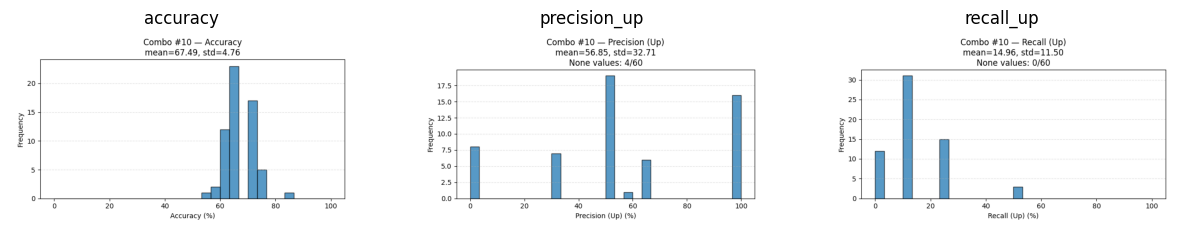

1.3


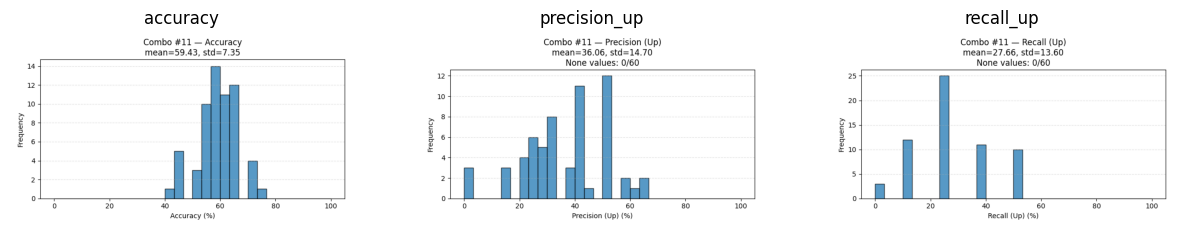

0.1


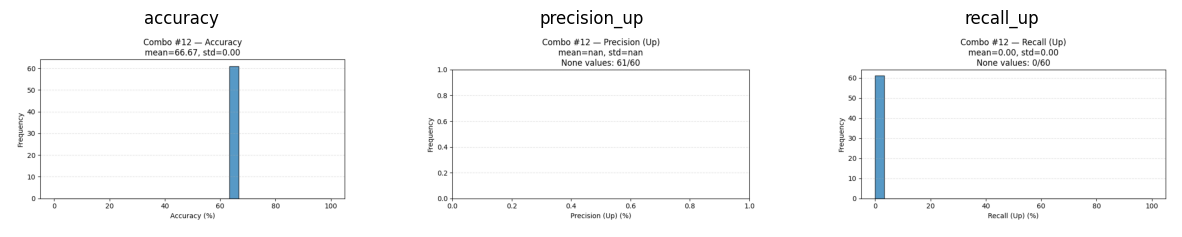

1


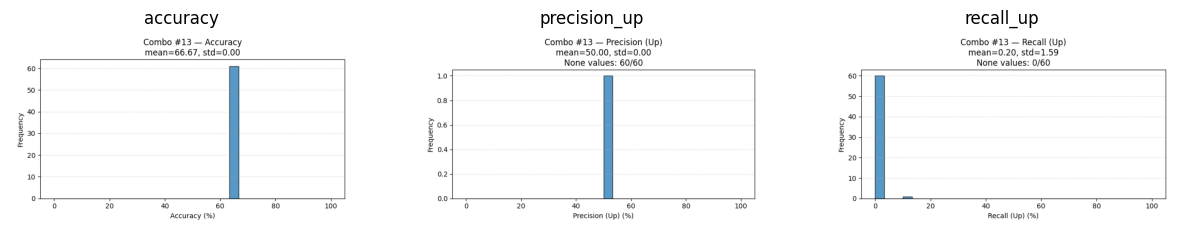

0.7


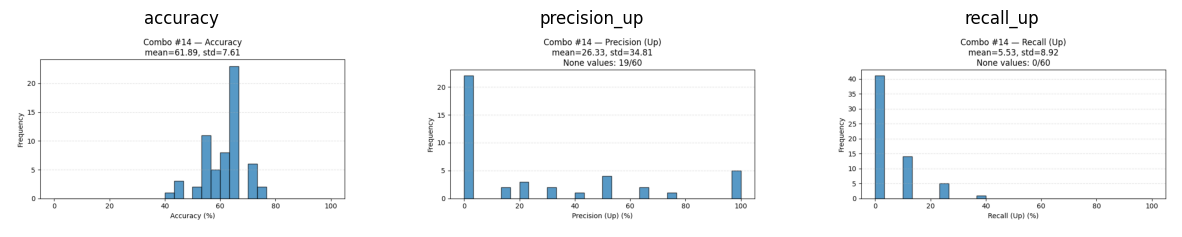

0.7


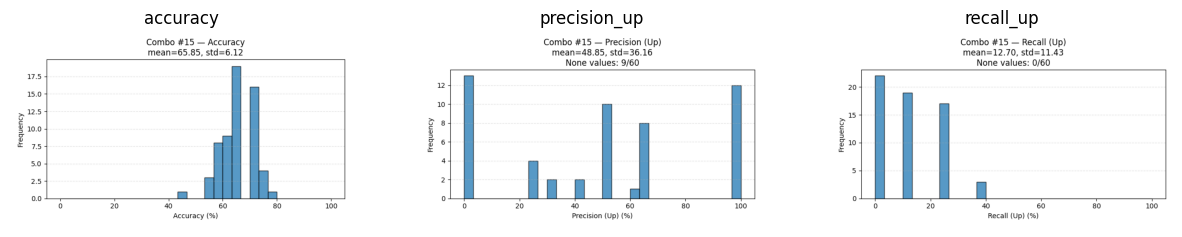

1


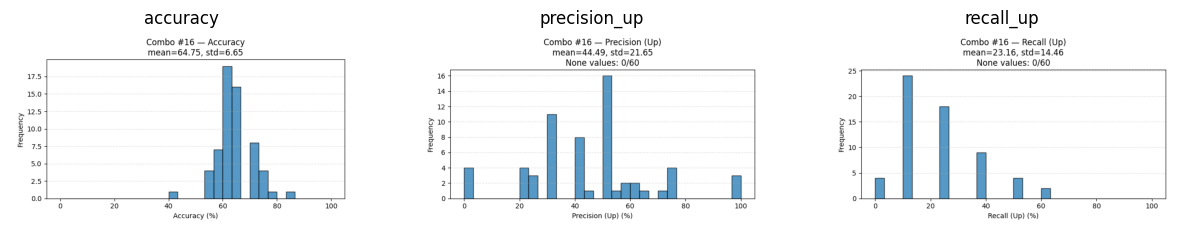

0.1


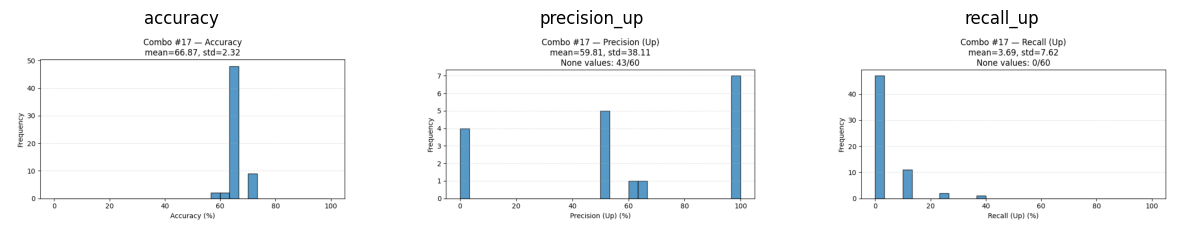

0.1


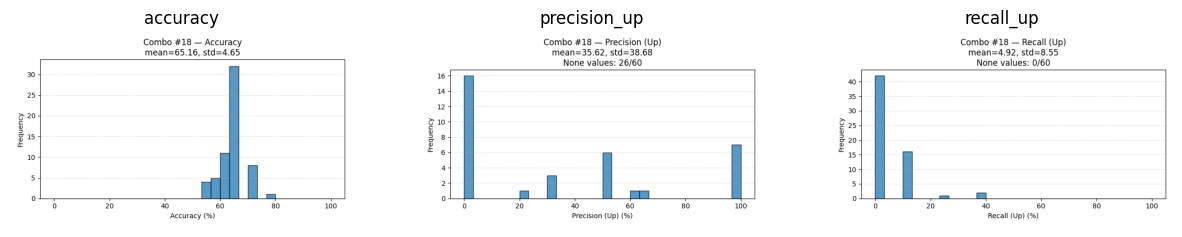

1


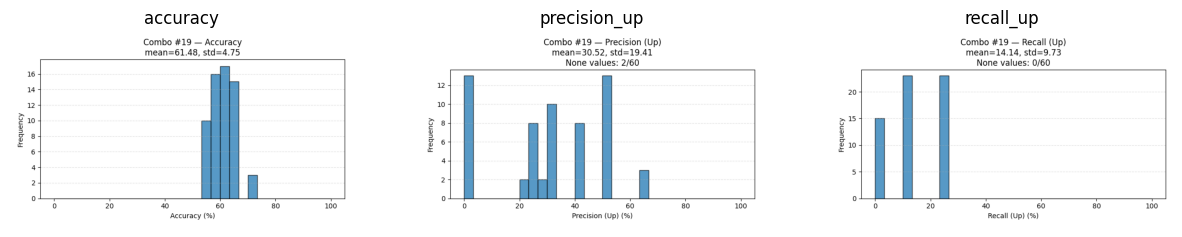

0.7


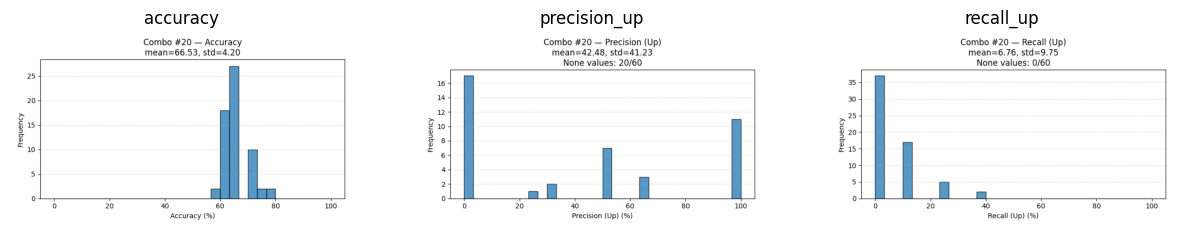

1


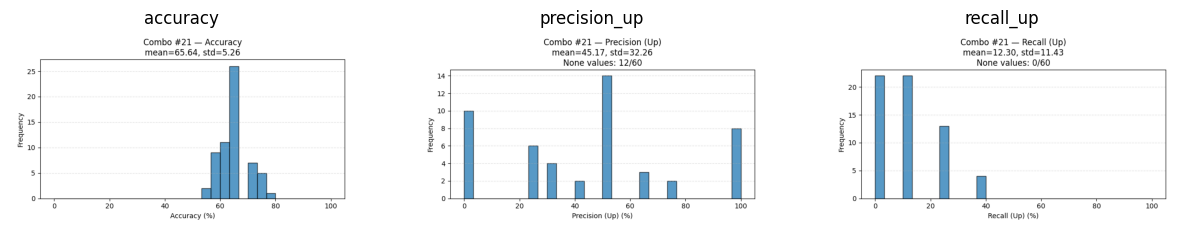

0.1


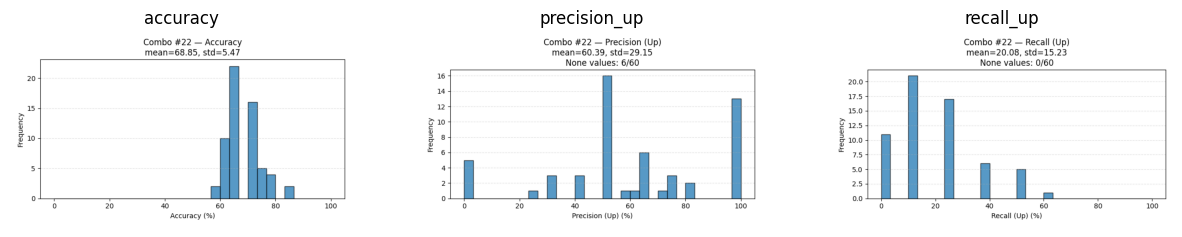

0.7


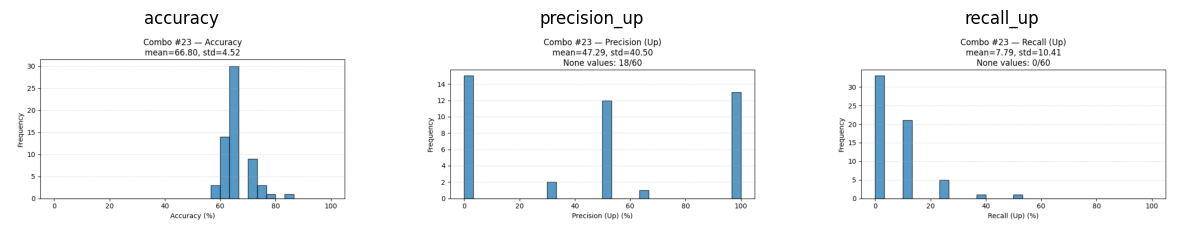

0.7


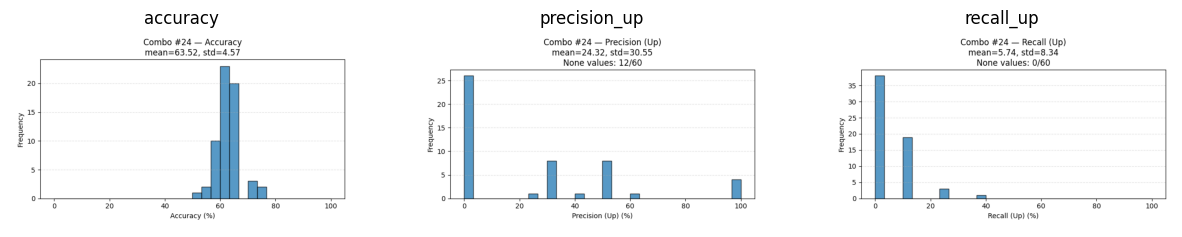

1.3


In [ ]:
import json

with open("/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/top_combos_dist_discovcery_25_combos_MAC.json") as f:
    results = json.load(f)



# for i in results:
#     print(i["combo_index"] , i["combo"]["POS_weight_multiplier"])

# for i in results:
#     for metric in ['accuracy', 'precision_up', 'recall_up']:
#         image_data = base64.b64decode(i["plots_base64"][metric])
#         display(Image(data=image_data))




import matplotlib.pyplot as plt
import base64
from io import BytesIO

metrics = ['accuracy', 'precision_up', 'recall_up']

for i in results:
    fig, axs = plt.subplots(1, len(metrics), figsize=(15, 5))  # one row, 3 cols
    for ax, metric in zip(axs, metrics):
        image_data = base64.b64decode(i["plots_base64"][metric])
        img = plt.imread(BytesIO(image_data), format="png")
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(metric)
    plt.show()
    print(i["combo"]["POS_weight_multiplier"])



In [ ]:




# for i in results:
#     print('combo index' , i["combo_index"])
#     for j in i["per_seed"]:
#         if j["precision_up"] > 60:
#             print(j)


In [ ]:
#                                     Preformers in the 60 - 80% range prec up 

# for i in results:
#     print('combo index' , i["combo_index"])
#     for j in i["per_seed"]:
#         if j["precision_up"] > 60:
#             print(j)


# #   CHARACTERISTICS OF THE CHOSEN MODELS 
# - PREFORM IN THE RANGE OF 60 - 80 PREC UP , TO AVOID OVERFITTING!
# - ONE TO TWO MODELS CHOSEN WITH THE SAME PARAMS BUT DIFF SEED 
# - NEXT STUDY CORRELATIONS ARE SEE IF SAME PARAM MODEL, WITH DIFF SEED OFC, ARE NOT CORRELATED 
# - TEST PREFROMANCE OF TEST SET 
# - RUN ENSEMBLES AND COMPATE TO PREVIOUS 
# - NEXT CAN TRY MODELS WITH 100 PREC UP, BUT I AM SKEPTICAL THIS OVERFITS ... DUE TO INITIAL RESULTS 

all_dicts = [
    {"combo_index_1": [
        {'seed': 42, 'accuracy': 79.16666666666666, 'precision_up': 71.42857142857143, 'recall_up': 62.5}
        # {'seed': 414, 'accuracy': 70.83333333333334, 'precision_up': 66.66666666666666, 'recall_up': 25.0},
    ]},
    {"combo_index_2": [
        {'seed': 5528, 'accuracy': 75.0, 'precision_up': 66.66666666666666, 'recall_up': 50.0}
        # {'seed': 6718, 'accuracy': 79.16666666666666, 'precision_up': 80.0, 'recall_up': 50.0},
    ]},
    {"combo_index_3": [
        {'seed': 8928, 'accuracy': 79.16666666666666, 'precision_up': 71.42857142857143, 'recall_up': 62.5}
        # {'seed': 6516, 'accuracy': 75.0, 'precision_up': 62.5, 'recall_up': 62.5},
    ]},
    {"combo_index_6": [
        {'seed': 2846, 'accuracy': 75.0, 'precision_up': 75.0, 'recall_up': 37.5}
        # {'seed': 7788, 'accuracy': 75.0, 'precision_up': 66.66666666666666, 'recall_up': 50.0},
    ]},
    {"combo_index_8": [
        {'seed': 6526, 'accuracy': 75.0, 'precision_up': 62.5, 'recall_up': 62.5}
        # {'seed': 5943, 'accuracy': 75.0, 'precision_up': 75.0, 'recall_up': 37.5},
    ]},
    {"combo_index_10": [
        {'seed': 8073, 'accuracy': 70.83333333333334, 'precision_up': 100.0, 'recall_up': 12.5}
        # {'seed': 508, 'accuracy': 75.0, 'precision_up': 66.66666666666666, 'recall_up': 50.0},
    ]},
    {"combo_index_22": [
        {'seed': 6825, 'accuracy': 79.16666666666666, 'precision_up': 80.0, 'recall_up': 50.0}
        # {'seed': 2363, 'accuracy': 75.0, 'precision_up': 75.0, 'recall_up': 37.5},
    ]},
    {"combo_index_16": [
        {'seed': 7155, 'accuracy': 79.16666666666666, 'precision_up': 71.42857142857143, 'recall_up': 62.5}
        # {'seed': 8329, 'accuracy': 70.83333333333334, 'precision_up': 66.66666666666666, 'recall_up': 25.0},
    ]},
]



for i in all_dicts:
    for j in results:
        if j["combo_index"] == int(list(i.keys())[0].split('_')[-1]):

            i["parameters"] = j["combo"]



In [ ]:
all_params_seeded = []

for d in all_dicts:
    params  = d["parameters"]
    seeds = [k["seed"] for k in list(d.values())[0]]


    for s in seeds:
        params["seed_num"] = s
        all_params_seeded.append(params)

In [ ]:
import copy
all_params_seeded


combos_test_param = []

for i in all_params_seeded:
    i_copy = copy.deepcopy(i)
    i_copy["val_set_fraction"] = 0.05
    i_copy["num_folds"] = 4
    i_copy["end_value_train_set_fraction"] = 0.95
    combos_test_param.append(i_copy)
 

In [ ]:
with parallel_backend("loky", n_jobs=-1):
    results_T = Parallel()(
        delayed(run_combo)(0, combo, i, use_print_acc_vs_pred=False)
        
        for i, (combo) in enumerate(combos_test_param)
    )

--- Running Combo 1 ---Parameters: {'learning_rate': 0.05, 'num_epochs': 70, 'batch_size': 50, 'use_bidirectional': False, 'lag': 3, 'input_size': 12, 'hidden_size': 55, 'num_layers': 1, 'use_monthly_dfs_only': True, 'use_binary_0_1': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': True, 'use_class_weighting': False, 'is_deterministic': True, 'seed_num': 42, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_custom_neg': True, 'use_binary_0_1_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.95, 'val_set_fraction': 0.05, 'num_folds': 4, 'POS_weight_multiplier': 0.7, 'use_rolling_fixed_train_size': False, 'use_existing_initial_weights': False, 'state_dict': None}

--- Running Combo 3 ---Parameters: {'learning_rate': 0.05, 'num_epochs': 150,

In [ ]:
with parallel_backend("loky", n_jobs=-1):
    results_V = Parallel()(
        delayed(run_combo)(0, combo, i, use_print_acc_vs_pred=False)
        
        for i, (combo) in enumerate(all_params_seeded)
    )

--- Running Combo 1 ---Parameters: {'learning_rate': 0.05, 'num_epochs': 70, 'batch_size': 50, 'use_bidirectional': False, 'lag': 3, 'input_size': 12, 'hidden_size': 55, 'num_layers': 1, 'use_monthly_dfs_only': True, 'use_binary_0_1': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': True, 'use_class_weighting': False, 'is_deterministic': True, 'seed_num': 42, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_custom_neg': True, 'use_binary_0_1_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.85, 'val_set_fraction': 0.1, 'num_folds': 8, 'POS_weight_multiplier': 0.7, 'use_rolling_fixed_train_size': False, 'use_existing_initial_weights': False, 'state_dict': None}

--- Running Combo 3 ---Parameters: {'learning_rate': 0.05, 'num_epochs': 150, 

In [ ]:
#                                       Top precision up preformers (100% if pssible)

# for i in results:
#     print('combo index' , i["combo_index"])
#     for j in i["per_seed"]:
#         if j["precision_up"] > 60:
#             print(j)


# #   CHARACTERISTICS OF THE CHOSEN MODELS 
# - PREFORM IN THE RANGE OF 60 - 80 PREC UP , TO AVOID OVERFITTING!
# - ONE TO TWO MODELS CHOSEN WITH THE SAME PARAMS BUT DIFF SEED 
# - NEXT STUDY CORRELATIONS ARE SEE IF SAME PARAM MODEL, WITH DIFF SEED OFC, ARE NOT CORRELATED 
# - TEST PREFROMANCE OF TEST SET 
# - RUN ENSEMBLES AND COMPATE TO PREVIOUS 
# - NEXT CAN TRY MODELS WITH 100 PREC UP, BUT I AM SKEPTICAL THIS OVERFITS ... DUE TO INITIAL RESULTS 

all_dicts = [
    {"combo_index_1": [
        {'seed': 42, 'accuracy': 79.16666666666666, 'precision_up': 71.42857142857143, 'recall_up': 62.5}
        # {'seed': 414, 'accuracy': 70.83333333333334, 'precision_up': 66.66666666666666, 'recall_up': 25.0},
    ]},
    {"combo_index_2": [
        # {'seed': 5528, 'accuracy': 75.0, 'precision_up': 66.66666666666666, 'recall_up': 50.0}
        {'seed': 127, 'accuracy': 79.16666666666666, 'precision_up': 100.0, 'recall_up': 37.5}

        # {'seed': 6718, 'accuracy': 79.16666666666666, 'precision_up': 80.0, 'recall_up': 50.0},
    ]},
    {"combo_index_3": [
        # {'seed': 8928, 'accuracy': 79.16666666666666, 'precision_up': 71.42857142857143, 'recall_up': 62.5}
        {'seed': 9805, 'accuracy': 75.0, 'precision_up': 75.0, 'recall_up': 37.5}

        # {'seed': 6516, 'accuracy': 75.0, 'precision_up': 62.5, 'recall_up': 62.5},
    ]},
    {"combo_index_6": [
        # {'seed': 2846, 'accuracy': 75.0, 'precision_up': 75.0, 'recall_up': 37.5}
        {'seed': 2662, 'accuracy': 79.16666666666666, 'precision_up': 100.0, 'recall_up': 37.5}

        # {'seed': 7788, 'accuracy': 75.0, 'precision_up': 66.66666666666666, 'recall_up': 50.0},
    ]},
    {"combo_index_8": [
        # {'seed': 6526, 'accuracy': 75.0, 'precision_up': 62.5, 'recall_up': 62.5}
        {'seed': 4376, 'accuracy': 75.0, 'precision_up': 75.0, 'recall_up': 37.5}
        # {'seed': 5943, 'accuracy': 75.0, 'precision_up': 75.0, 'recall_up': 37.5},
    ]},
    {"combo_index_10": [
        # {'seed': 8073, 'accuracy': 70.83333333333334, 'precision_up': 100.0, 'recall_up': 12.5}
        {'seed': 2900, 'accuracy': 83.33333333333334, 'precision_up': 100.0, 'recall_up': 50.0}

        # {'seed': 508, 'accuracy': 75.0, 'precision_up': 66.66666666666666, 'recall_up': 50.0},
    ]},
    {"combo_index_22": [
        # {'seed': 6825, 'accuracy': 79.16666666666666, 'precision_up': 80.0, 'recall_up': 50.0}
        {'seed': 1321, 'accuracy': 83.33333333333334, 'precision_up': 100.0, 'recall_up': 50.0}

        # {'seed': 2363, 'accuracy': 75.0, 'precision_up': 75.0, 'recall_up': 37.5},
    ]},
    {"combo_index_16": [
        # {'seed': 7155, 'accuracy': 79.16666666666666, 'precision_up': 71.42857142857143, 'recall_up': 62.5}
        {'seed': 7997, 'accuracy': 83.33333333333334, 'precision_up': 100.0, 'recall_up': 50.0}

        # {'seed': 8329, 'accuracy': 70.83333333333334, 'precision_up': 66.66666666666666, 'recall_up': 25.0},
    ]},
]



for i in all_dicts:
    for j in results:
        if j["combo_index"] == int(list(i.keys())[0].split('_')[-1]):

            i["parameters"] = j["combo"]



In [ ]:
all_params_seeded = []

for d in all_dicts:
    params  = d["parameters"]
    seeds = [k["seed"] for k in list(d.values())[0]]


    for s in seeds:
        params["seed_num"] = s
        all_params_seeded.append(params)

In [ ]:
import copy
all_params_seeded


combos_test_param = []

for i in all_params_seeded:
    i_copy = copy.deepcopy(i)
    i_copy["val_set_fraction"] = 0.05
    i_copy["num_folds"] = 4
    i_copy["end_value_train_set_fraction"] = 0.95
    combos_test_param.append(i_copy)
 

In [ ]:
with parallel_backend("loky", n_jobs=-1):
    results_T_h = Parallel()(
        delayed(run_combo)(0, combo, i, use_print_acc_vs_pred=False)
        
        for i, (combo) in enumerate(combos_test_param)
    )

--- Running Combo 1 ---Parameters: {'learning_rate': 0.05, 'num_epochs': 70, 'batch_size': 50, 'use_bidirectional': False, 'lag': 3, 'input_size': 12, 'hidden_size': 55, 'num_layers': 1, 'use_monthly_dfs_only': True, 'use_binary_0_1': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': True, 'use_class_weighting': False, 'is_deterministic': True, 'seed_num': 42, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_custom_neg': True, 'use_binary_0_1_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.95, 'val_set_fraction': 0.05, 'num_folds': 4, 'POS_weight_multiplier': 0.7, 'use_rolling_fixed_train_size': False, 'use_existing_initial_weights': False, 'state_dict': None}

--- Running Combo 3 ---Parameters: {'learning_rate': 0.05, 'num_epochs': 150,

In [ ]:
with parallel_backend("loky", n_jobs=-1):
    results_V_h = Parallel()(
        delayed(run_combo)(0, combo, i, use_print_acc_vs_pred=False)
        
        for i, (combo) in enumerate(all_params_seeded)
    )

--- Running Combo 1 ---Parameters: {'learning_rate': 0.05, 'num_epochs': 70, 'batch_size': 50, 'use_bidirectional': False, 'lag': 3, 'input_size': 12, 'hidden_size': 55, 'num_layers': 1, 'use_monthly_dfs_only': True, 'use_binary_0_1': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': True, 'use_class_weighting': False, 'is_deterministic': True, 'seed_num': 42, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_custom_neg': True, 'use_binary_0_1_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.85, 'val_set_fraction': 0.1, 'num_folds': 8, 'POS_weight_multiplier': 0.7, 'use_rolling_fixed_train_size': False, 'use_existing_initial_weights': False, 'state_dict': None}

--- Running Combo 2 ---Parameters: {'learning_rate': 0.05, 'num_epochs': 150, 

In [ ]:


r_V_h ,w = zip(*results_V_h)

r_T_h ,w = zip(*results_T_h)

# for i in r:
#     print(i["cv_sets"]["overall_metrics"])


for i in r_T_h:
    print(i["parameters"])

{'learning_rate': 0.05, 'num_epochs': 70, 'batch_size': 50, 'use_bidirectional': False, 'lag': 3, 'input_size': 12, 'hidden_size': 55, 'num_layers': 1, 'use_monthly_dfs_only': True, 'use_binary_0_1': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': True, 'use_class_weighting': False, 'is_deterministic': True, 'seed_num': 42, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_custom_neg': True, 'use_binary_0_1_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.95, 'val_set_fraction': 0.05, 'num_folds': 4, 'POS_weight_multiplier': 0.7, 'use_rolling_fixed_train_size': False, 'use_existing_initial_weights': False, 'state_dict': None}
{'learning_rate': 0.05, 'num_epochs': 150, 'batch_size': 50, 'use_bidirectional': False, 'lag': 3, 'input_size': 

In [ ]:
import json




import json
import numpy as np

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (np.integer, np.int64)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return super().default(obj)
    


file_json_metrics = f"/Users/cs/Desktop/top_combos_dist_discovcery_high_prec_seeds_results_MAC_V.json"


with open(file_json_metrics, "w") as f_json:
    json.dump(r_V_h, f_json, cls=NumpyEncoder, indent=2)



file_json_metrics = f"/Users/cs/Desktop/top_combos_dist_discovcery_high_prec_seeds_results_MAC_T.json"


with open(file_json_metrics, "w") as f_json:
    json.dump(r_T_h, f_json, cls=NumpyEncoder, indent=2)




In [12]:
import json

with open("/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/top_combos_dist_discovcery_25_combos_MAC.json") as f:
    results = json.load(f)




In [ ]:
#                                    ALL ALL ALL ALL 

# for i in results:
#     print('combo index' , i["combo_index"])
#     for j in i["per_seed"]:
#         if j["precision_up"] > 60:
#             print(j)


# #   CHARACTERISTICS OF THE CHOSEN MODELS 
# - PREFORM IN THE RANGE OF 60 - 80 PREC UP , TO AVOID OVERFITTING!
# - ONE TO TWO MODELS CHOSEN WITH THE SAME PARAMS BUT DIFF SEED 
# - NEXT STUDY CORRELATIONS ARE SEE IF SAME PARAM MODEL, WITH DIFF SEED OFC, ARE NOT CORRELATED 
# - TEST PREFROMANCE OF TEST SET 
# - RUN ENSEMBLES AND COMPATE TO PREVIOUS 
# - NEXT CAN TRY MODELS WITH 100 PREC UP, BUT I AM SKEPTICAL THIS OVERFITS ... DUE TO INITIAL RESULTS 

all_dicts = [
    {"combo_index_1": [
        {'seed': 42, 'accuracy': 79.16666666666666, 'precision_up': 71.42857142857143, 'recall_up': 62.5},
        {'seed': 414, 'accuracy': 70.83333333333334, 'precision_up': 66.66666666666666, 'recall_up': 25.0}
    ]},
    {"combo_index_2": [
        {'seed': 5528, 'accuracy': 75.0, 'precision_up': 66.66666666666666, 'recall_up': 50.0},
        {'seed': 127, 'accuracy': 79.16666666666666, 'precision_up': 100.0, 'recall_up': 37.5}

        # {'seed': 6718, 'accuracy': 79.16666666666666, 'precision_up': 80.0, 'recall_up': 50.0},
    ]},
    {"combo_index_3": [
        {'seed': 8928, 'accuracy': 79.16666666666666, 'precision_up': 71.42857142857143, 'recall_up': 62.5},
        {'seed': 9805, 'accuracy': 75.0, 'precision_up': 75.0, 'recall_up': 37.5}

        # {'seed': 6516, 'accuracy': 75.0, 'precision_up': 62.5, 'recall_up': 62.5},
    ]},
    {"combo_index_6": [
        {'seed': 2846, 'accuracy': 75.0, 'precision_up': 75.0, 'recall_up': 37.5},
        {'seed': 2662, 'accuracy': 79.16666666666666, 'precision_up': 100.0, 'recall_up': 37.5}

        # {'seed': 7788, 'accuracy': 75.0, 'precision_up': 66.66666666666666, 'recall_up': 50.0},
    ]},
    {"combo_index_8": [
        {'seed': 6526, 'accuracy': 75.0, 'precision_up': 62.5, 'recall_up': 62.5},
        {'seed': 4376, 'accuracy': 75.0, 'precision_up': 75.0, 'recall_up': 37.5}
        # {'seed': 5943, 'accuracy': 75.0, 'precision_up': 75.0, 'recall_up': 37.5},
    ]},
    {"combo_index_10": [
        # {'seed': 8073, 'accuracy': 70.83333333333334, 'precision_up': 100.0, 'recall_up': 12.5},
        {'seed': 2900, 'accuracy': 83.33333333333334, 'precision_up': 100.0, 'recall_up': 50.0}

        # {'seed': 508, 'accuracy': 75.0, 'precision_up': 66.66666666666666, 'recall_up': 50.0},
    ]},
    {"combo_index_22": [
        {'seed': 6825, 'accuracy': 79.16666666666666, 'precision_up': 80.0, 'recall_up': 50.0},
        {'seed': 1321, 'accuracy': 83.33333333333334, 'precision_up': 100.0, 'recall_up': 50.0}

        # {'seed': 2363, 'accuracy': 75.0, 'precision_up': 75.0, 'recall_up': 37.5},
    ]},
    {"combo_index_16": [
        {'seed': 7155, 'accuracy': 79.16666666666666, 'precision_up': 71.42857142857143, 'recall_up': 62.5},
        {'seed': 7997, 'accuracy': 83.33333333333334, 'precision_up': 100.0, 'recall_up': 50.0}

        # {'seed': 8329, 'accuracy': 70.83333333333334, 'precision_up': 66.66666666666666, 'recall_up': 25.0},
    ]},
]



for i in all_dicts:
    for j in results:
        if j["combo_index"] == int(list(i.keys())[0].split('_')[-1]):

            i["parameters"] = j["combo"]

for i in all_dicts:
    print(i["parameters"])

{'learning_rate': 0.05, 'num_epochs': 70, 'batch_size': 50, 'use_bidirectional': False, 'lag': 3, 'input_size': 12, 'hidden_size': 55, 'num_layers': 1, 'use_monthly_dfs_only': True, 'use_binary_0_1': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': True, 'use_class_weighting': False, 'is_deterministic': True, 'seed_num': 42, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_custom_neg': True, 'use_binary_0_1_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.85, 'val_set_fraction': 0.1, 'num_folds': 8, 'POS_weight_multiplier': 0.7, 'use_rolling_fixed_train_size': False, 'use_existing_initial_weights': False, 'state_dict': None}
{'learning_rate': 0.05, 'num_epochs': 150, 'batch_size': 50, 'use_bidirectional': False, 'lag': 3, 'input_size': 1

In [ ]:
for d in all_dicts:
    for i in d.values():
        print(i)

[{'seed': 42, 'accuracy': 79.16666666666666, 'precision_up': 71.42857142857143, 'recall_up': 62.5}, {'seed': 414, 'accuracy': 70.83333333333334, 'precision_up': 66.66666666666666, 'recall_up': 25.0}]
{'learning_rate': 0.05, 'num_epochs': 70, 'batch_size': 50, 'use_bidirectional': False, 'lag': 3, 'input_size': 12, 'hidden_size': 55, 'num_layers': 1, 'use_monthly_dfs_only': True, 'use_binary_0_1': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': True, 'use_class_weighting': False, 'is_deterministic': True, 'seed_num': 42, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_custom_neg': True, 'use_binary_0_1_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.85, 'val_set_fraction': 0.1, 'num_folds': 8, 'POS_weight_multiplier': 0.7, 'use_rolling

In [ ]:
import copy

all_params_seeded = []

for d in all_dicts:
    params = d["parameters"]
    seeds = [k["seed"] for k in list(d.values())[0]]

    for s in seeds:
        p = copy.deepcopy(params)  # new independent dict
        p["seed_num"] = s
        all_params_seeded.append(p)

# for i in all_params_seeded:
#     print(i["seed_num"])

# import copy
# all_params_seeded


# combos_test_param = []

# for i in all_params_seeded:
#     i_copy = copy.deepcopy(i)
#     i_copy["val_set_fraction"] = 0.05
#     i_copy["num_folds"] = 4
#     i_copy["end_value_train_set_fraction"] = 0.95
#     combos_test_param.append(i_copy)
 
all_params_seeded


[{'learning_rate': 0.05,
  'num_epochs': 70,
  'batch_size': 50,
  'use_bidirectional': False,
  'lag': 3,
  'input_size': 12,
  'hidden_size': 55,
  'num_layers': 1,
  'use_monthly_dfs_only': True,
  'use_binary_0_1': False,
  'use_binary_neg1_1': False,
  'use_ret_rate': False,
  'use_print_acc': False,
  'use_dropout': True,
  'use_class_weighting': False,
  'is_deterministic': True,
  'seed_num': 42,
  'use_monthly_predictor': False,
  'use_existing_lagged_data': True,
  'use_dynamic_weights': False,
  'use_monthly_daily_end_mo_predictor': False,
  'use_monthly_weekly_end_mo_predictor': True,
  'use_binary_0_1_custom_neg': True,
  'use_binary_0_1_custom_pos': False,
  'binary_0_1_cutoff_ret_rate_percentage': 0.05,
  'end_value_train_set_fraction': 0.85,
  'val_set_fraction': 0.1,
  'num_folds': 8,
  'POS_weight_multiplier': 0.7,
  'use_rolling_fixed_train_size': False,
  'use_existing_initial_weights': False,
  'state_dict': None},
 {'learning_rate': 0.05,
  'num_epochs': 70,
  'ba

In [ ]:
from joblib import Parallel, delayed , parallel_backend


with parallel_backend("loky", n_jobs=-1):
    results = Parallel()(
        delayed(run_combo)(0, combo, i, use_print_acc_vs_pred=False)
        
        for i, (combo) in enumerate(all_params_seeded)
    )

KeyboardInterrupt: 

In [ ]:


r,w = zip(*results)


# for i in r:
#     print(i["cv_sets"]["overall_metrics"])




15

In [ ]:



import json
import numpy as np

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (np.integer, np.int64)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return super().default(obj)
    

# Your existing code
file_json_metrics = f"/Users/cs/Desktop/dist_discovcery_chosen_combos_lowANDhigh_prec_MAC_V_results.json"

with open(file_json_metrics, "w") as f_json:
    json.dump(  r   , f_json, cls=NumpyEncoder, indent=2)



--- 
# TESTING
--- 

In [ ]:
with open('/Users/cs/Desktop/full_results_chunk_1_25_CHUNKS_8fold_05NEG__VERSION_4__GSresults.json', 'r') as f:
    results = json.load(f)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/cs/Desktop/full_results_chunk_1_25_CHUNKS_8fold_05NEG__VERSION_4__GSresults.json'

In [ ]:
# import json
# import numpy as np


# results_chunks = {}


# # Load all 8-fold results from the specified directory
# for i in range(2):

#     with open(f'/Users/cs/Desktop/full_results_chunk_{i + 1}_15_CHUNKS_8fold_05NEG__VERSION_3.json', 'r') as f:
#         results_chunks[f'CV_Results_chunk_{i + 1}'] = json.load(f)



# all_results = []

# for i in results_chunks["CV_Results_chunk_1"]:
#     all_results.append(i)

# for i in results_chunks["CV_Results_chunk_2"]:
#     all_results.append(i)





# # Step 1: Compute scores
# scored_results = []
# for entry in all_results:
#     avg = entry['cv_sets'].get('avg_across_all_sets', {})
#     acc = avg.get('accuracy', 0.0) or 0.0
#     prec_up = avg.get('precision_up', 0.0) or 0.0

#     total_score = acc + prec_up
#     scored_results.append((total_score, entry))

# # Step 2: Sort by score descending
# scored_results.sort(reverse=True, key=lambda x: x[0])

# # Step 3: Extract top 10 entries
# top = scored_results[:25]


# top


# for i, j in top:
#     print(j["cv_sets"]["avg_across_all_sets"])

# combos = []

# for i, j in top:
#     combos.append(j["parameters"])

# combos

In [ ]:
# from joblib import parallel_backend
# from joblib import Parallel
# from joblib import delayed


# # for i in combos:
# #     run_combo(4, i, 4, use_print_acc_vs_pred=False)


# with parallel_backend("loky", n_jobs=-1):
#     results = Parallel()(
#         delayed(run_combo)(0, combo, 0, use_print_acc_vs_pred=False)
        
#         for i, combo in enumerate(combos)
#     )

# # --- Unzip results ---
# metrics_list, weights_list = zip(*results)


--- Running Combo 1 ---Parameters: {'learning_rate': 0.05, 'num_epochs': 70, 'batch_size': 50, 'use_bidirectional': False, 'lag': 3, 'input_size': 12, 'hidden_size': 5, 'num_layers': 4, 'use_monthly_dfs_only': True, 'use_binary_0_1': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': True, 'use_class_weighting': True, 'is_deterministic': True, 'seed_num': 42, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_custom_neg': True, 'use_binary_0_1_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.85, 'val_set_fraction': 0.1, 'num_folds': 8, 'POS_weight_multiplier': 0.7, 'use_rolling_fixed_train_size': True, 'use_existing_initial_weights': False, 'state_dict': None}

--- Running Combo 1 ---Parameters: {'learning_rate': 0.05, 'num_epochs': 70, 'bat

: 

: 

: 

: 

: 

: 

In [ ]:


# import random
# import matplotlib.pyplot as plt
# import numpy as np


# # To display the plot in a Jupyter notebook:
# from IPython.display import Image, display
# import base64

# ###################################################################################################### LOOPS THROUGH EACH COMBINATION, RUNS X TIMES WITH RANDOMLY CHOSEN SEED TO BUILD OUT A DISTRIBUTION 
# #*#**#*#*#*#*#**#*#*#*#**#*#*#*#*#**#*#*#*#**#*#*#*#*#**#*#*#*#**#*#*#*#*#**#*#*#*#**#*#*#*#*#**#*#*        WITH IN PARALLALIZATION WITHIN FUNCTION  

# random.seed(12345)

# import random, io, base64, math
# import numpy as np
# import matplotlib.pyplot as plt
# from joblib import Parallel, delayed, parallel_backend

# random.seed(12345)

# def distribution_discovery(combo: dict, combo_index: int , number_of_seeds: int):
#     """
#     Run the same combo across many different seeds by overriding combo['seed_num'].
#     Uses the current run_combo signature:
#         run_combo(INDEX, combo, total_offset, use_print_acc_vs_pred)
#     Extracts the 'avg_across_all_sets' → 'accuracy' and plots its distribution.
#     Returns a dict with seeds, summary, and a base64-encoded PNG of the histogram.
#     """
#     print(f"****************** STARTED RUN FOR COMBO INDEX {combo_index}")

#     # choose seeds

#     seeds = random.sample(range(10000), number_of_seeds)
#     if 42 not in seeds:
#         seeds.append(42)

#     def run_for_seed(seed_val):
#         # override seed in combo (DO NOT mutate original)
#         combo_seeded = dict(combo)
#         combo_seeded['seed_num'] = seed_val
#         combo_seeded['is_deterministic'] = True  # ensure deterministic path uses the provided seed

#         # run
#         result_entry, _ = run_combo(0, combo_seeded, total_offset=0, use_print_acc_vs_pred=False)

#         # extract avg accuracy across folds
#         try:
#             avg_acc = result_entry['cv_sets']['avg_across_all_sets'].get('accuracy', np.nan)
#         except Exception:
#             avg_acc = np.nan

#         return {'seed': seed_val, 'avg_accuracy': float(avg_acc) if avg_acc is not None else np.nan}

#     # parallel runs
#     with parallel_backend("loky"):
#         per_seed = Parallel(n_jobs=4)(delayed(run_for_seed)(s) for s in seeds)

#     # summary stats
#     accs = np.array([r['avg_accuracy'] for r in per_seed], dtype=np.float64)
#     mean_acc = float(np.nanmean(accs)) if np.isfinite(accs).any() else float('nan')
#     std_acc  = float(np.nanstd(accs))  if np.isfinite(accs).any() else float('nan')

#     # plot histogram of avg accuracies (across all folds) over seeds
#     fig = plt.figure(figsize=(7, 4))
#     plt.hist(accs[~np.isnan(accs)], bins=25, range = (0,100), edgecolor='black', alpha=0.75)
#     plt.xlabel("Avg Accuracy Across CV Folds (%)")
#     plt.ylabel("Frequency")
#     plt.title(f"Combo #{combo_index} — mean={mean_acc:.2f}, std={std_acc:.2f}")
#     plt.grid(axis='y', linestyle='--', alpha=0.4)
#     plt.tight_layout()

#     # encode figure to base64
#     buf = io.BytesIO()
#     plt.savefig(buf, format='png')
#     buf.seek(0)
#     img_b64 = base64.b64encode(buf.read()).decode('utf-8')
#     plt.close(fig)

#     return {
#         'combo_index': combo_index,
#         'combo': combo,
#         # 'seeds': seeds,
#         'per_seed': per_seed,  # list of {'seed', 'avg_accuracy'}
#         'summary_stats': {'mean': mean_acc, 'std': std_acc},
#         'plot_base64': img_b64,
#     }


# c =  {'learning_rate': 0.05,
#   'num_epochs': 70,
#   'batch_size': 50,
#   'use_bidirectional': False,
#   'lag': 3,
#   'input_size': 12,
#   'hidden_size': 5,
#   'num_layers': 4,
#   'use_monthly_dfs_only': True,
#   'use_binary_0_1': False,
#   'use_binary_neg1_1': False,
#   'use_ret_rate': False,
#   'use_print_acc': False,
#   'use_dropout': True,
#   'use_class_weighting': True,
#   'is_deterministic': True,
#   'seed_num': 42,
#   'use_monthly_predictor': False,
#   'use_existing_lagged_data': True,
#   'use_dynamic_weights': False,
#   'use_monthly_daily_end_mo_predictor': False,
#   'use_monthly_weekly_end_mo_predictor': True,
#   'use_binary_0_1_custom_neg': True,
#   'use_binary_0_1_custom_pos': False,
#   'binary_0_1_cutoff_ret_rate_percentage': 0.05,
#   'end_value_train_set_fraction': 0.85,
#   'val_set_fraction': 0.1,
#   'num_folds': 8,
#   'POS_weight_multiplier': 0.7,
#   'use_rolling_fixed_train_size': True,
#   'use_existing_initial_weights': False,
#   'state_dict': None}



# # with parallel_backend("loky"):
# #     parallel_results = Parallel(n_jobs=-1)(
# #         delayed(distribution_discovery)(run, combo_index=i , number_of_seeds = 5)
# #         for i, run in enumerate(top_combos_dicts)
# #     )





# res = distribution_discovery(c, combo_index= , number_of_seeds = 200)


SyntaxError: expected argument value expression (3173363536.py, line 135)

: 

: 

: 

In [ ]:
# image_data = base64.b64decode(res["plot_base64"])
# display(Image(data=image_data))



NameError: name 'base64' is not defined

: 

: 

: 

In [ ]:
# image_data = base64.b64decode(res["plot_base64"])
# display(Image(data=image_data))




# import pickle
# with open('/Users/cs/Desktop/Oil-LSTM-Project-2-2/short_dfs.pkl', 'rb') as f:
#     loaded_dfs = pickle.load(f)

# with open("/Users/cs/Desktop/Oil-LSTM-Project-2-2/lagged_cache.pkl", "rb") as f:
#     lagged_cache = pickle.load(f)



: 

: 

: 

In [ ]:

import pandas as pd
import pickle
import random
import numpy as np
import os
import itertools
from joblib import Parallel, delayed
from collections import defaultdict
import math
import copy

import torch.nn as nn

import torch
c =  {'learning_rate': 0.05,
  'num_epochs': 7,
  'batch_size': 50,
  'use_bidirectional': False,
  'lag': 3,
  'input_size': 12,
  'hidden_size': 5,
  'num_layers': 4,
  'use_monthly_dfs_only': True,
  'use_binary_0_1': False,
  'use_binary_neg1_1': False,
  'use_ret_rate': False,
  'use_print_acc': False,
  'use_dropout': True,
  'use_class_weighting': True,
  'is_deterministic': True,
  'seed_num': 42,
  'use_monthly_predictor': False,
  'use_existing_lagged_data': True,
  'use_dynamic_weights': False,
  'use_monthly_daily_end_mo_predictor': False,
  'use_monthly_weekly_end_mo_predictor': True,
  'use_binary_0_1_custom_neg': True,
  'use_binary_0_1_custom_pos': False,
  'binary_0_1_cutoff_ret_rate_percentage': 0.05,
  'end_value_train_set_fraction': 0.85,
  'val_set_fraction': 0.1,
  'num_folds': 8,
  'POS_weight_multiplier': 0.7,
  'use_rolling_fixed_train_size': True,
  'use_existing_initial_weights': False,
  'state_dict': None}


a,b = run_combo_ensemble(2,c,3,False)

--- Running Combo 6 ---Parameters: {'learning_rate': 0.05, 'num_epochs': 7, 'batch_size': 50, 'use_bidirectional': False, 'lag': 3, 'input_size': 12, 'hidden_size': 5, 'num_layers': 4, 'use_monthly_dfs_only': True, 'use_binary_0_1': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': True, 'use_class_weighting': True, 'is_deterministic': True, 'seed_num': 42, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_custom_neg': True, 'use_binary_0_1_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.85, 'val_set_fraction': 0.1, 'num_folds': 8, 'POS_weight_multiplier': 0.7, 'use_rolling_fixed_train_size': True, 'use_existing_initial_weights': False, 'state_dict': None}



: 

: 

: 

In [ ]:
from joblib import parallel_backend , Parallel



models_combo_list = [{'learning_rate': 0.05,'num_epochs': 7,'batch_size': 50,'use_bidirectional': False,
  'lag': 3,'input_size': 12,'hidden_size': 5,'num_layers': 4,'use_monthly_dfs_only': True,'use_binary_0_1': False,'use_binary_neg1_1': False,'use_ret_rate': False,
  'use_print_acc': False,'use_dropout': True,'use_class_weighting': True,'is_deterministic': True,'seed_num': 42,'use_monthly_predictor': False,'use_existing_lagged_data': True,'use_dynamic_weights': False,
  'use_monthly_daily_end_mo_predictor': False,'use_monthly_weekly_end_mo_predictor': True,'use_binary_0_1_custom_neg': True,'use_binary_0_1_custom_pos': False,
  'binary_0_1_cutoff_ret_rate_percentage': 0.05,'end_value_train_set_fraction': 0.85,'val_set_fraction': 0.1,'num_folds': 8,
  'POS_weight_multiplier': 0.7,'use_rolling_fixed_train_size': True,'use_existing_initial_weights': False,'state_dict': None}

  , 

  {'learning_rate': 0.05,'num_epochs': 7,'batch_size': 50,'use_bidirectional': False,'lag': 3,'input_size': 12,'hidden_size': 5,'num_layers': 4,
  'use_monthly_dfs_only': True,'use_binary_0_1': False,'use_binary_neg1_1': False,'use_ret_rate': False,'use_print_acc': False,'use_dropout': True,'use_class_weighting': True,'is_deterministic': True,
  'seed_num': 42,'use_monthly_predictor': False,'use_existing_lagged_data': True,'use_dynamic_weights': False,
  'use_monthly_daily_end_mo_predictor': False,'use_monthly_weekly_end_mo_predictor': True,'use_binary_0_1_custom_neg': True,'use_binary_0_1_custom_pos': False,
  'binary_0_1_cutoff_ret_rate_percentage': 0.05,'end_value_train_set_fraction': 0.85,'val_set_fraction': 0.1,'num_folds': 8,
  'POS_weight_multiplier': 0.7,'use_rolling_fixed_train_size': True,'use_existing_initial_weights': False,'state_dict': None}


]


# --- Run in parallel ---
with parallel_backend("loky", n_jobs=-1):
    all_results  = Parallel()(
        delayed(run_combo_ensemble)(i, combo, 10, use_print_acc_vs_pred=False)
        for i, combo in enumerate(models_combo_list)
    )

results, weights  = zip(*all_results)

# Step 1: Collect all_preds from each model
all_model_preds = [res["all_preds"] for res in results]  # shape: (num_models, num_folds)

# Step 2: Transpose so we group predictions per fold across models
transposed_preds = list(zip(*all_model_preds))  # shape: (num_folds, num_models)

# Step 3: Average predictions for each fold
avg_preds_per_fold = [np.mean(np.stack(preds), axis=0) for preds in transposed_preds]







--- Running Combo 11 ---Parameters: {'learning_rate': 0.05, 'num_epochs': 7, 'batch_size': 50, 'use_bidirectional': False, 'lag': 3, 'input_size': 12, 'hidden_size': 5, 'num_layers': 4, 'use_monthly_dfs_only': True, 'use_binary_0_1': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': True, 'use_class_weighting': True, 'is_deterministic': True, 'seed_num': 42, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_custom_neg': True, 'use_binary_0_1_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.85, 'val_set_fraction': 0.1, 'num_folds': 8, 'POS_weight_multiplier': 0.7, 'use_rolling_fixed_train_size': True, 'use_existing_initial_weights': False, 'state_dict': None}

--- Running Combo 12 ---Parameters: {'learning_rate': 0.05, 'num_epochs': 7, 'bat

: 

: 

: 

[array([0.35402727, 0.3556526 , 0.35261515], dtype=float32),
 array([0.5897745, 0.5900981, 0.5899443], dtype=float32),
 array([0.48919123, 0.48928595, 0.489183  ], dtype=float32),
 array([0.36290085, 0.3627126 , 0.36174676], dtype=float32),
 array([0.48281696, 0.48331463, 0.48422357], dtype=float32),
 array([0.3729734 , 0.37605792, 0.37456033], dtype=float32),
 array([0.36590055, 0.36802793, 0.3658256 ], dtype=float32),
 array([0.49046436, 0.49121776, 0.4913105 ], dtype=float32)]

: 

: 

: 

In [ ]:
np.stack(transposed_preds[0])
transposed_preds[0]


(array([0.35402727, 0.3556526 , 0.35261515], dtype=float32),
 array([0.35402727, 0.3556526 , 0.35261515], dtype=float32))

: 

: 

: 

In [ ]:
import pickle
with open('/Users/cs/Desktop/Oil-LSTM-Project-2/short_dfs.pkl', 'rb') as f:
    loaded_dfs = pickle.load(f)

with open("/Users/cs/Desktop/Oil-LSTM-Project-2/lagged_cache.pkl", "rb") as f:
    lagged_cache = pickle.load(f)


: 

: 

: 

In [ ]:
# one model - take the avg fo the restuls many times 

# many models - take the avg of the results (could also take the avg of the models over different seeds first)

# selective model 




list_all_preds = []

for array_fold in a["all_preds"]:
    for value in array_fold:
        list_all_preds.append(value) 

def ensemble_function (use_simple_avg : bool, 
                       model_results_1 : list , model_results_2 : list ,model_results_3 : list , num_models :  ):
                       
                    #    ,model_results_4 : list ,model_results_5 : list ,model_results_6 : list )

    cv_data = {}  

    models_list = 


    if use_simple_avg: 
            
        avg_results = []

        num_models = 3

        for set_idx , (fold1   ,  fold2   ,   fold3) in enumerate(zip( model_results_1,model_results_2,model_results_3 )):
            avg = (fold1  +  fold2  +  fold3) / num_models
            avg_results.append(avg)



            metrics = evaluate_binary_0_1(predicted_array, actual_array, do_print=use_print_acc)



            cv_data[f"set_{set_idx + 1}"] = metrics
 

        # === Compute overall average ===
        metrics_keys = cv_data[f"set_{set_idx + 1}"].keys()

        overall_avg = {}
        for k in metrics_keys:
            values = [cv_data[f"set_{i + 1}"][k] for i in range(num_cv_sets)]
            # For string values (i.e., "No 'up' samples..."), skip them in averaging
            numeric_values = [v for v in values if v is not None and not (isinstance(v, float) and np.isnan(v)) and isinstance(v, (int, float))]
            if len(numeric_values) > 0:
                overall_avg[k] = np.mean(numeric_values)

            else:
                overall_avg[k] = None
            # else:
            #     # If all values are string messages, keep the message
            #     string_values = [v for v in values if isinstance(v, str)]
            #     overall_avg[k] = string_values[0] if string_values else np.nan
        cv_data["avg_across_all_sets"] = overall_avg

        return cv_data , model_weight_dict  

    cv_data , model_weight_dict = GRIDSEARCH_FUNCTION_WITH_CV_forTS(**combo)

    


    result_entry = {
        "combo_number": total_offset + INDEX + 1,
        "parameters": combo,
        "cv_sets": cv_data,
    }

    print(
        f"--- Running Combo {total_offset + INDEX + 1} ---" 
        f"Parameters: {combo}\n" ,
        # f"→ Fold Accuracies: " +
        # "  ".join(
        #     f"{k}: {cv_data[k][0]['accuracy']}"  # <-- each set is now a list of metric dicts 
        #     for k in sorted(cv_data) if k.startswith("set_")
        # ) +
        # f"\n→ Overall Avg Accuracy: {cv_data['avg_across_all_sets']['accuracy']}",
        flush=True
    )

    return result_entry ,model_weight_dict


ensemble_function (use_simple_avg  = True, 
                       model_results_1 = a["all_preds"], 
                       model_results_2 = a["all_preds"] ,
                       model_results_3 = a["all_preds"] )



# a["all_preds"]


[array([0.12543239, 0.09037582, 0.25464922], dtype=float32),
 array([0.43697914, 0.2516038 , 0.28423998], dtype=float32),
 array([0.39297518, 0.45505437, 0.52827805], dtype=float32),
 array([0.2518047, 0.579028 , 0.6116389], dtype=float32),
 array([0.40713605, 0.3878775 , 0.38475809], dtype=float32),
 array([0.18569678, 0.5774644 , 0.10767   ], dtype=float32),
 array([0.23631914, 0.30201563, 0.41839305], dtype=float32),
 array([0.9239113 , 0.91865396, 0.89724296], dtype=float32)]

: 

: 

: 

In [ ]:
a["all_preds"]

[array([0.35402727, 0.3556526 , 0.35261515], dtype=float32),
 array([0.5897745, 0.5900981, 0.5899443], dtype=float32),
 array([0.48919123, 0.48928595, 0.489183  ], dtype=float32),
 array([0.36290085, 0.3627126 , 0.36174676], dtype=float32),
 array([0.48281696, 0.48331463, 0.48422357], dtype=float32),
 array([0.3729734 , 0.37605792, 0.37456033], dtype=float32),
 array([0.36590055, 0.36802793, 0.3658256 ], dtype=float32),
 array([0.49046436, 0.49121776, 0.4913105 ], dtype=float32)]

: 

: 

: 

In [ ]:
test = ()

test.append(2)

AttributeError: 'tuple' object has no attribute 'append'

: 

: 

: 